In [141]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize

In [123]:
def cvt_local2global(local_point, sc_point):
    x, y, a = local_point.T
    X, Y, A = sc_point.T
    x1 = x * np.cos(A) - y * np.sin(A) + X
    y1 = x * np.sin(A) + y * np.cos(A) + Y
    a1 = (a + A) % (2 * np.pi)
    return np.array([x1, y1, a1]).T


def cvt_global2local(global_point, sc_point):
    x, y, a = global_point.T
    X, Y, A = sc_point.T
    x1 = x * np.cos(A) + y * np.sin(A) - X * np.cos(A) - Y * np.sin(A)
    y1 = -x * np.sin(A) + y * np.cos(A) + X * np.sin(A) - Y * np.cos(A)
    a1 = (a - A) % (2 * np.pi)
    return np.array([x1, y1, a1]).T

def find_src(global_point, local_point):
    x, y, a = local_point.T
    x1, y1, a1 = global_point.T
    A = (a1 - a) % (2 * np.pi)
    X = x1 - x * np.cos(A) + y * np.sin(A)
    Y = y1 - x * np.sin(A) - y * np.cos(A)
    return np.array([X, Y, A]).T

In [124]:
# Dimensions of the playing field
WORLD_X = 3000
WORLD_Y = 2000
WORLD_BORDER = 22
BEAC_R = 96.0 / 2
BEAC_L = 100.0
BEAC_BORDER = 22.0

ORANGE_BEACONS = np.array([[WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., WORLD_Y / 2.],
                           [-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), WORLD_Y - BEAC_L / 2.],
                           [-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), BEAC_L / 2.]])

GREEN_BEACONS = np.array([[-(WORLD_BORDER + BEAC_BORDER + BEAC_L / 2.), WORLD_Y / 2.],
                          [WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., WORLD_Y - BEAC_L / 2.],
                          [WORLD_X + WORLD_BORDER + BEAC_BORDER + BEAC_L / 2., BEAC_L / 2.]])

# parameters of lidar
LIDAR_DELTA_ANGLE = (np.pi / 180) / 4
LIDAR_START_ANGLE = -(np.pi / 2 + np.pi / 4)


class ParticleFilter:
    def __init__(self, particles_num=500, sense_noise=50, distance_noise=5, angle_noise=0.02, start_x=293, start_y=425,
                 start_angle=3 * np.pi / 2, color='orange', min_intens=3500.0, max_dist=3700.0,
                 k_angle=4, beac_dist_thresh=300, num_is_near_thresh=0.1, dist_offset=0, k_bad = 0.5):

        self.start_coords = np.array([start_x, start_y, start_angle])
        self.color = color
        if color == 'orange':
            self.beacons = ORANGE_BEACONS
        else:
            self.beacons = GREEN_BEACONS

        self.last = (start_x, start_y, start_angle)
        
        self.particles_num = particles_num
        self.sense_noise = sense_noise
        self.distance_noise = distance_noise
        self.angle_noise = angle_noise
        self.min_intens = min_intens
        self.max_dist = max_dist
        self.k_angle = k_angle
        self.beac_dist_thresh = beac_dist_thresh
        self.num_is_near_thresh = num_is_near_thresh
        self.dist_offset = dist_offset
        self.num_seeing_beacons = 3
        self.k_bad = k_bad

        # Create Particles
        x = np.random.normal(start_x, distance_noise, particles_num)
        y = np.random.normal(start_y, distance_noise, particles_num)
        angle = np.random.normal(start_angle, angle_noise, particles_num) % (2 * np.pi)
        self.particles = np.array([x, y, angle]).T
        self.landmarks = [[], []]
        
        self.min_cost_function = 0

    @staticmethod
    def gaus(x, mu=0, sigma=1):
        """calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma"""
        return np.exp(- ((x - mu) ** 2) / (sigma ** 2) / 2.0) / np.sqrt(2.0 * np.pi * (sigma ** 2))

    @staticmethod
    def p_trans(a, d):
        x_beac = d * np.cos(a)
        y_beac = d * np.sin(a)
        return x_beac, y_beac
    
    def localisation(self, delta_coords, lidar_data):
        self.move_particles([delta_coords[0], delta_coords[1], delta_coords[2]])
        self.particles = self.particle_sense(lidar_data, self.particles)
        main_robot = self.calculate_main()
        return main_robot

    def particle_sense(self, scan, particles):
        angle, distance = self.get_landmarks(scan, self.min_intens)
        x_coords, y_coords = self.p_trans(angle, distance)
        self.landmarks = np.array([x_coords, y_coords]).T
        weights = self.weights(self.landmarks, particles)
        inds = self.resample(weights)
        self.min_cost_function = np.mean(self.cost_function)
        particles = particles[inds, :]
        return particles
    
    def move_particles(self, delta):  # delta = [dx,dy,d_rot]
        if self.num_seeing_beacons in [2, 3]:
            d_n = self.distance_noise
            a_n = self.angle_noise
        elif self.num_seeing_beacons == 1:
            d_n = self.distance_noise / 8
            a_n = self.angle_noise / 2
        else:
            a_n = self.angle_noise
            d_n = self.distance_noise
#         d_n = self.distance_noise
#         a_n = self.angle_noise
        x_noise = np.random.normal(0, d_n, self.particles_num)
        y_noise = np.random.normal(0, d_n, self.particles_num)
        angle_noise = np.random.normal(0, a_n, self.particles_num)
        noise = np.array([x_noise, y_noise, angle_noise]).T
        move_point = delta + noise
        self.particles = cvt_local2global(move_point, self.particles)
        self.particles[self.particles[:, 1] > 2000 - 120, 1] = 2000 - 120
        self.particles[self.particles[:, 1] < 0, 1] = 0
        self.particles[self.particles[:, 0] > 3000 - 120, 0] = 3000 - 120
        self.particles[self.particles[:, 0] < 120, 0] = 120

    def resample(self, weights):
        """ according to weights """
        n = self.particles_num
        weigths = np.array(weights)
        indices = []
        C = np.append([0.], np.cumsum(weigths))
        j = 0
        u0 = (np.random.rand() + np.arange(n)) / n
        for u in u0:
            while j < len(C) and u > C[j]:
                j += 1
            indices += [j - 1]
        return indices

    def calculate_main(self):
        x = np.mean(self.particles[:, 0])
        y = np.mean(self.particles[:, 1])
        zero_elem = self.particles[0, 2]
        # this helps if particles angles are close to 0 or 2*pi
        temporary = ((self.particles[:, 2] - zero_elem + np.pi) % (2.0 * np.pi)) + zero_elem - np.pi
        angle = np.mean(temporary) % (2.0 * np.pi)
        return np.array((x, y, angle))

    def weights(self, landmarks, particles):
        """Calculate particle weights based on their pose and landmards"""
        # determines 3 beacon positions (x,y) for every particle in it's local coords
        res = self.beacons[np.newaxis, :, :] - particles[:, np.newaxis, :2]
        X = (res[:, :, 0] * np.cos(particles[:, 2])[:, np.newaxis]
             + res[:, :, 1] * np.sin(particles[:, 2])[:, np.newaxis])
        Y = (-res[:, :, 0] * np.sin(particles[:, 2])[:, np.newaxis]
             + res[:, :, 1] * np.cos(particles[:, 2])[:, np.newaxis])
        beacons = np.concatenate((X[:, :, np.newaxis], Y[:, :, np.newaxis]), axis=2)
        
        # find closest beacons to landmark
        dist_from_beacon = np.linalg.norm(beacons[:, np.newaxis, :, :] -
                                          landmarks[np.newaxis, :, np.newaxis, :], axis=3)
        ind_closest_beacon = np.argmin(dist_from_beacon, axis=2)
        closest_beacons = beacons[np.arange(beacons.shape[0])[:, np.newaxis], ind_closest_beacon]
        
        # Calculate cos of angle between landmark, beacon and particle
        scalar_product = np.sum((closest_beacons - particles[:, np.newaxis, :2]) *
                                (closest_beacons - landmarks[np.newaxis, :, :2]), axis=2)
        dist_from_closest_beacon_to_particle = np.linalg.norm(closest_beacons - particles[:, np.newaxis, :2], axis=2)
        dist_from_closest_beacon_to_landmark = np.linalg.norm(closest_beacons - landmarks[np.newaxis, :, :2], axis=2) 
        cos_landmarks = scalar_product /\
                        np.where(dist_from_closest_beacon_to_landmark, dist_from_closest_beacon_to_landmark, 1) /\
                        np.where(dist_from_closest_beacon_to_particle, dist_from_closest_beacon_to_particle, 1)
        

        # From local minimum
        res = closest_beacons - landmarks[np.newaxis, :, :2]
        X = (res[:, :, 0] * np.cos(particles[:, 2])[:, np.newaxis]
             - res[:, :, 1] * np.sin(particles[:, 2])[:, np.newaxis])
        Y = (res[:, :, 0] * np.sin(particles[:, 2])[:, np.newaxis]
             + res[:, :, 1] * np.cos(particles[:, 2])[:, np.newaxis])
        delta_beacon_landmark = np.concatenate((X[:, :, np.newaxis], Y[:, :, np.newaxis]), axis=2)
        if self.color == "orange":
            is_bad_beacon_landmark_x = \
                (ind_closest_beacon == 0) * (delta_beacon_landmark[:, :, 0] < 0) +\
                (ind_closest_beacon == 1) * (delta_beacon_landmark[:, :, 0] > 0) +\
                (ind_closest_beacon == 2) * (delta_beacon_landmark[:, :, 0] > 0)
        else:
            is_bad_beacon_landmark_x = \
                (ind_closest_beacon == 0) * (delta_beacon_landmark[:, :, 0] > 0) +\
                (ind_closest_beacon == 1) * (delta_beacon_landmark[:, :, 0] < 0) +\
                (ind_closest_beacon == 2) * (delta_beacon_landmark[:, :, 0] < 0)
        is_bad_beacon_landmark_y = \
            (ind_closest_beacon == 1) * (delta_beacon_landmark[:, :, 1] < 0) +\
            (ind_closest_beacon == 2) * (delta_beacon_landmark[:, :, 1] > 0)
        # Calculate errors of position of landmarks
        errors = np.abs(dist_from_closest_beacon_to_landmark - BEAC_R) ** 2 +\
                 self.k_angle * np.abs(1 - cos_landmarks) ** 2 +\
                 self.k_bad * is_bad_beacon_landmark_x * delta_beacon_landmark[:, :, 0] ** 2 +\
                 self.k_bad * is_bad_beacon_landmark_y * delta_beacon_landmark[:, :, 1] ** 2
     
        # too far real beacons go away: non valid
        is_near = dist_from_closest_beacon_to_landmark < self.beac_dist_thresh
        is_near_sum = np.sum(is_near, axis=0)
        is_near_or = (is_near_sum > is_near.shape[0] * self.num_is_near_thresh)
        self.is_near_or = is_near_or
        num_good_landmarks = np.sum(is_near_or)
        sum_errors = np.sum(errors * is_near_or[np.newaxis, :], axis=1)
            
        max_good_landmark = np.max(num_good_landmarks)
        if num_good_landmarks:
            self.cost_function = np.sqrt(sum_errors) / num_good_landmarks
        else:
            self.cost_function = np.ones(sum_errors.shape[0]) * 1000
        
        is_beacon_seeing = np.ones(3) * False
        for i in range(3):
            is_beacon_seeing[i] = np.any(i == ind_closest_beacon[:, is_near_or])
        self.num_seeing_beacons = np.sum(is_beacon_seeing)
    
        weights = self.gaus(self.cost_function, mu=0, sigma=self.sense_noise)
        if np.sum(weights) > 0:
            weights /= np.sum(weights)
        else:
            weights = np.ones(particles.shape[0], dtype=np.float) / particles.shape[0]
            
        self.best_particles = {}
        self.particles1 = self.particles.copy()
        self.weights1 = weights.copy()
        best_particles_inds = np.argsort(self.cost_function)[:10]
        self.best_particles["particles"] = particles[best_particles_inds]
        self.best_particles["cost_function"] = self.cost_function[best_particles_inds]
        self.best_particles["num_good_landmarks"] = num_good_landmarks# [best_particles_inds]
        self.best_particles["weights"] = weights[best_particles_inds]
        self.is_beacon_seeing = is_beacon_seeing
        return weights
    
    def get_landmarks(self, scan, min_intens):
        """Returns filtrated lidar data"""
        ind = np.where(np.logical_and(scan[:, 1] > min_intens, scan[:, 0] < self.max_dist))[0]
        angles = (LIDAR_DELTA_ANGLE * ind + LIDAR_START_ANGLE) % (2 * np.pi)
        distances = scan[ind, 0]
#         self.intens = np.sqrt(scan[ind, 1])
        return angles, distances - self.dist_offset

In [99]:
np.array([True]) + np.array([True])

array([ True])

In [79]:
START_POINTS = np.array([[735, 1080, 1.57],
                         [280, 525, 4.71],
                         [600, 950, 4.71],
                         [760, 1012, 4.71],
                         [754, 690, 4.71],
                         [120, 525, 4.71],
                         [800, 1400, 3.14],
                         [170, 1730, 5.50],
                         [610, 1835, 3.14],
                         [2175, 570, 2.45],
                         [2090, 510, 4.71],
                         [0, 0, 0],
                         [2180, 590, 3.30],
                         [1486, 893, 0.2],
                         [767, 944, 1],
                         [2795, 1800, 0],
                         [2700, 1253, 3.14],
                         [900, 540, 1.57]])

LIDAR_POINTS = np.array([[0, 60, 1.57],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [-25, 36, 1.63],
                         [0, 60, 1.57],
                         [0, 60, 1.57],
                         [0, 0, 0],
                         [-25, 36, 1.63],
                         [0, 60, 1.57],
                         [0, 60, 1.57],
                         [0, 60, 1.57],
                         [-25, 36, 1.63],
                         [0, 60, 1.57],
                         [0, 60, 1.57]])
COLORS = ["orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "orange",
          "green",
          "green",
          "green",
          "green",
          "green",
          "green",
          "green",
          "green",
          "green",
          "orange"]

In [18]:
k = 18
start_point = START_POINTS[k - 1]
lidar_point = LIDAR_POINTS[k - 1]
start_lidar_point = cvt_local2global(lidar_point, start_point)

In [19]:
pf = ParticleFilter(color=COLORS[k], start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2])

# Read data

In [20]:
scans = np.load("laser_scans%d.npy"%k)
N = scans.shape[0]

(-200, 2200)

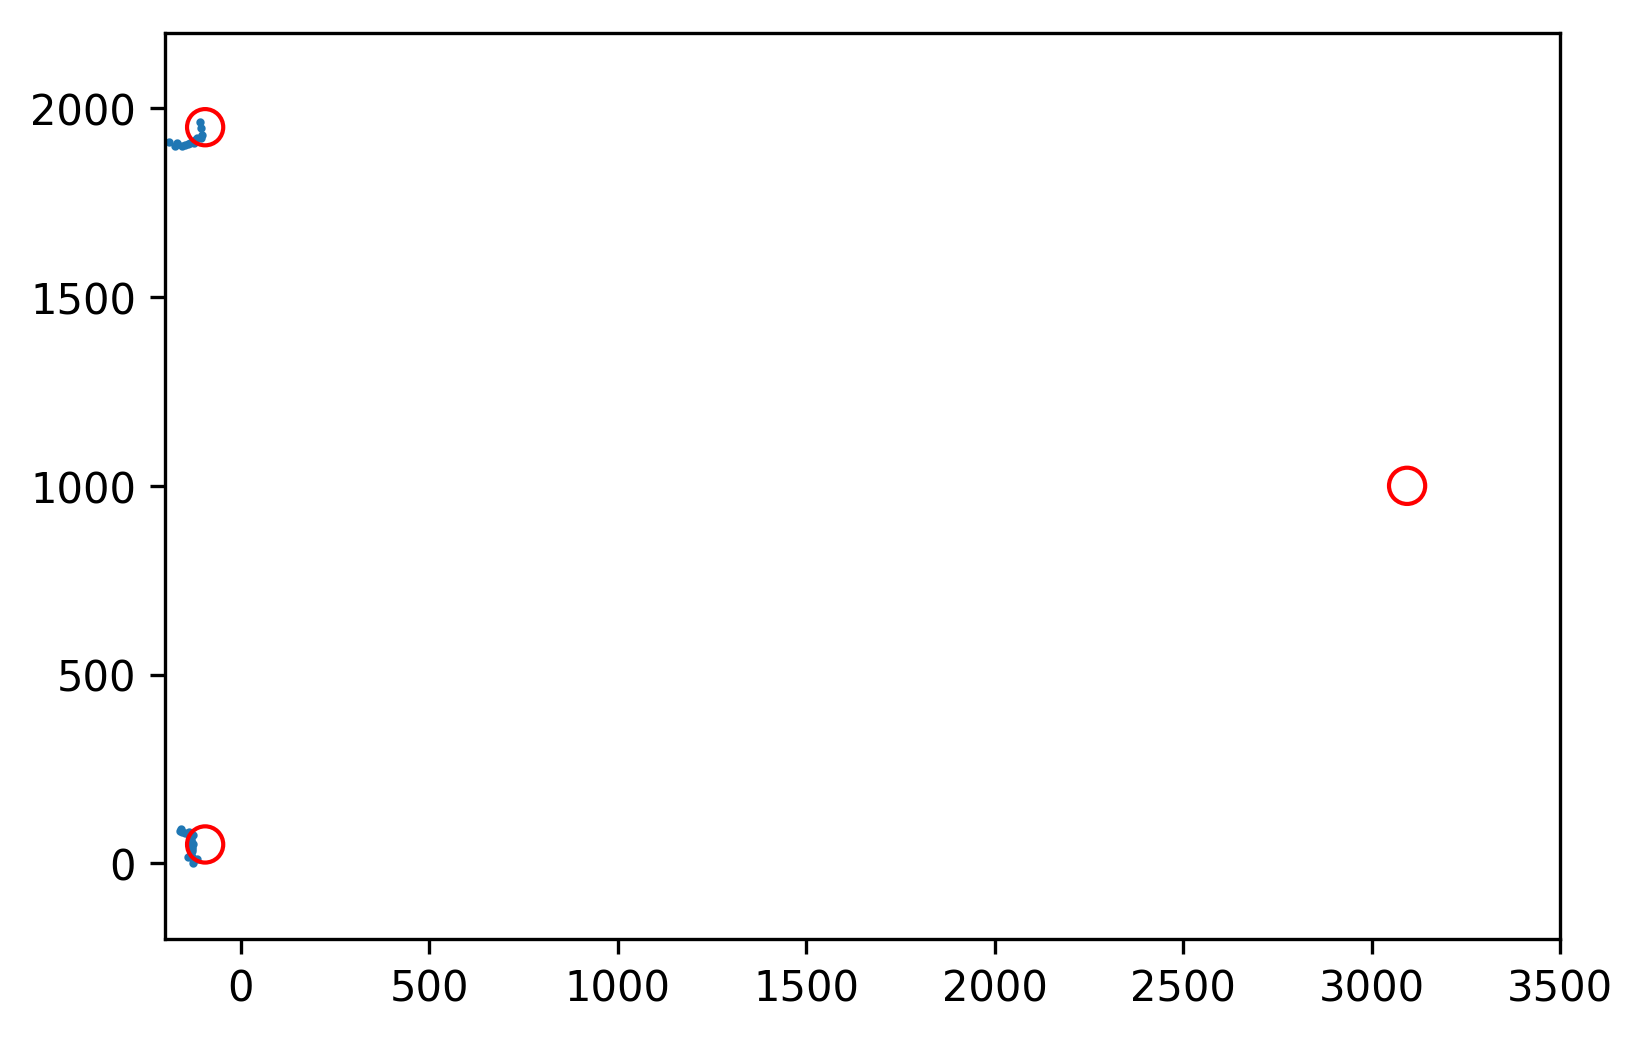

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(0, 1):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i], pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, start_lidar_point)[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
plt.xlim(-200, 3500)
plt.ylim(-200, 2200)

# Get odometry movement

In [22]:
raw_odom_coords = np.load("odom_coords%d.npy"%k)
raw_odom_coords[:, :2] *= 1000

In [23]:
odom_diff = cvt_global2local(raw_odom_coords, raw_odom_coords[0])
odom_robot_points = cvt_local2global(odom_diff, start_point)
odom_lidar_points = cvt_local2global(lidar_point, odom_robot_points)

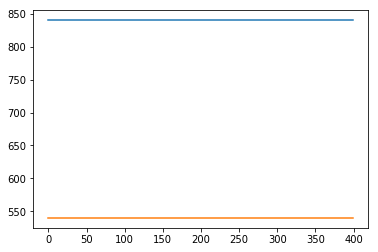

In [24]:
plt.plot(odom_lidar_points[:, 0])
plt.plot(odom_lidar_points[:, 1])

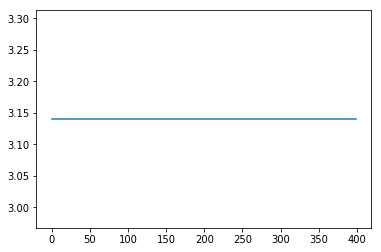

In [25]:
plt.plot(odom_lidar_points[:, 2])

## Laser scans in odom frames

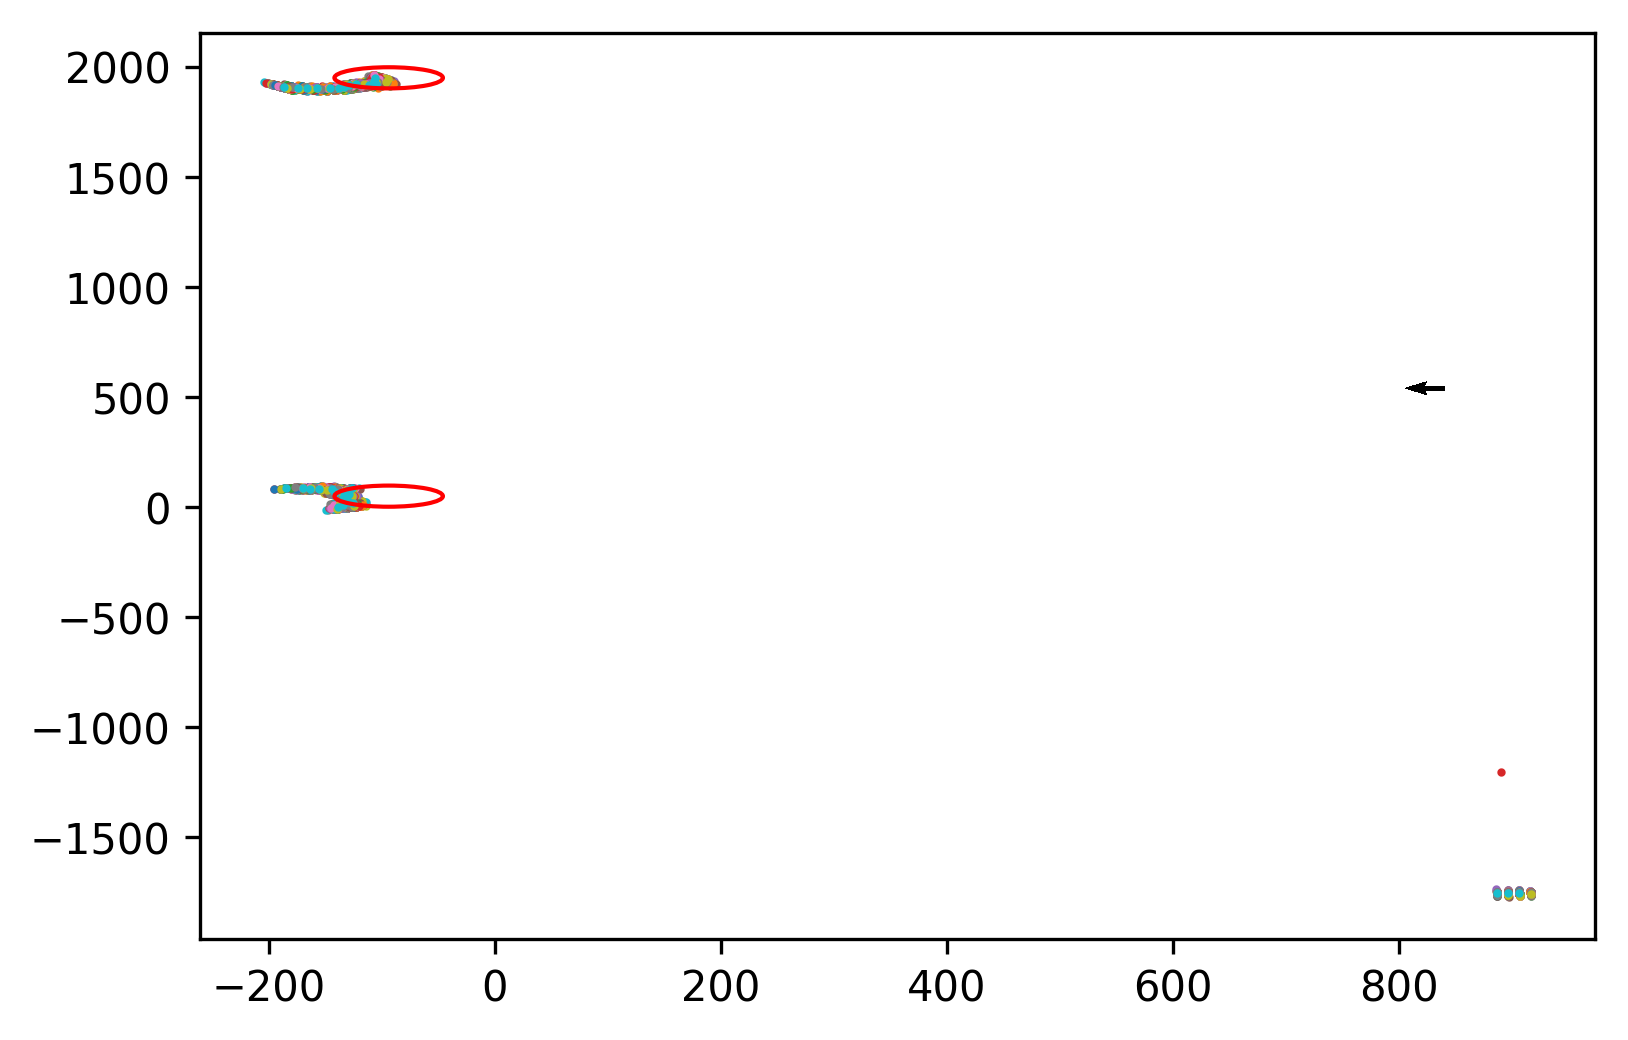

In [26]:
ind_start, ind_end = 0, N
ps = odom_lidar_points[ind_start:ind_end]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(ind_start, ind_end):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i], pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, odom_lidar_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]))
# plt.xlim(-200, 3200)
# plt.ylim(-200, 2200)

## Delta coords

In [27]:
delta_coords = cvt_global2local(odom_lidar_points, np.roll(odom_lidar_points, 1, axis=0))
delta_coords[0] = np.array([0, 0, 0])
delta_coords[-1] = np.array([0, 0, 0])

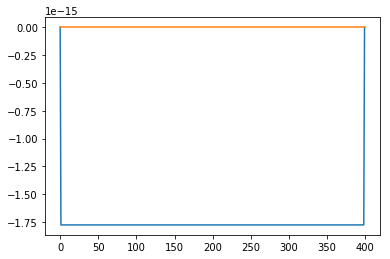

In [28]:
plt.plot(delta_coords[:, 0])
plt.plot(delta_coords[:, 1])

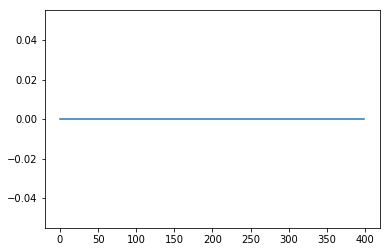

In [29]:
plt.plot(np.where(delta_coords[:, 2] < np.pi, delta_coords[:, 2], -2 * np.pi + delta_coords[:, 2]))

# Try PF

In [80]:
# sense_noise = 10
# distance_noise = 1
# angle_noise = 0.15
# max_itens=3000
# back_side_cost=10

In [134]:
PF_PARAMS = {"particles_num": 1000,
             "sense_noise": 0.75,
             "distance_noise": 8,
             "angle_noise": 0.1,
             "min_intens": 3000,
             "max_dist": 3700,
             "k_angle": 120,
             "beac_dist_thresh": 150,
             "num_is_near_thresh": 0.1,
             "dist_offset": 0,
             "k_bad": 1}

In [135]:
%%time
pf = ParticleFilter(color=COLORS[k], start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], **PF_PARAMS)
pf_points = []
cost_functions = []
all_particles = []
best_particles_information = []
all_particles1 = []
all_weights = []
all_is_near = []
all_is_beacon_seeing = []
for i in range(N):
    pf_points.append(pf.localisation(delta_coords[i], scans[i]))
    best_particles_information.append(pf.best_particles)
    cost_functions.append(pf.min_cost_function)
    all_particles.append(pf.particles.copy())
    all_particles1.append(pf.particles1.copy())
    all_weights.append(pf.weights1)
    all_is_near.append(pf.is_near_or)
    all_is_beacon_seeing.append(pf.is_beacon_seeing)
all_particles1 = np.array(all_particles1)
all_weights = np.array(all_weights)
pf_points = np.array(pf_points)
all_particles = np.array(all_particles)
all_is_near = np.array(all_is_near)
all_is_beacon_seeing = np.array(all_is_beacon_seeing)

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[  105.61248563    39.34869556]
  [  101.28727135    57.39136754]
  [   97.4327358     74.57640535]
  ...
  [-1122.24750381  1785.50729671]
  [-1132.82407352  1791.59163842]
  [-1142.69461597  1789.66348815]]

 [[ -152.21734122   -95.86367016]
  [ -153.57847      -77.35981058]
  [ -154.61327852   -59.77822532]
  ...
  [ -776.4551582   1800.50826186]
  [ -785.91300884  1808.21748375]
  [ -795.96526361  1807.90516053]]

 [[  -46.42297626   -58.22079721]
  [  -49.01582497   -39.84900834]
  [  -51.22153782   -22.37566293]
  ...
  [ -922.59952271  1788.03431394]
  [ -932.55072547  1795.09523488]
  [ -942.5597336   1794.11282562]]

 ...

 [[  173.43871623   114.65386662]
  [  168.00197893   132.39329667]
  [  163.08824402   149.30595992]
  ...
  [-1278.36158793  1777.572414  ]
  [-1289.29540501  1782.98856439]
  [-1299.02724132  1780.45149251]]

 [[   26.05465572 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[  -61.82908122   -20.07439197]
  [  -59.15268653   -10.95931414]
  [  -54.25219077    -5.1304526 ]
  ...
  [-1099.17264018  1755.60148267]
  [-1109.15881505  1756.2154422 ]
  [-1119.33295733  1760.7812466 ]]

 [[ -120.14238915   -44.54375819]
  [ -117.14468607   -35.52924164]
  [ -112.04072444   -29.87768776]
  ...
  [-1026.58837432  1765.58164006]
  [-1036.54652244  1766.54907017]
  [-1046.55248785  1771.47252394]]

 [[ -261.94682644  -125.49459968]
  [ -257.98982476  -116.85805696]
  [ -252.30343403  -111.79293643]
  ...
  [ -760.96619734  1761.0149358 ]
  [ -770.760846    1763.05588958]
  [ -780.17429327  1769.03474829]]

 ...

 [[ -321.77126002  -161.80818735]
  [ -317.54933645  -153.29801146]
  [ -311.709182    -148.41097949]
  ...
  [ -703.57497193  1738.31032663]
  [ -713.30189388  1740.65289449]
  [ -722.52614182  1746.91971113]]

 [[  -57.59285403 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[-1.19352756e+02 -4.54025280e+01]
  [-1.13118839e+02 -4.15047033e+01]
  [-1.07973369e+02 -3.58909153e+01]
  ...
  [-1.00517995e+03  1.78524825e+03]
  [-1.01521805e+03  1.78624558e+03]
  [-1.02524429e+03  1.78419890e+03]]

 [[-1.04965393e+02 -3.48779735e+01]
  [-9.87824783e+01 -3.08997440e+01]
  [-9.37101397e+01 -2.52197909e+01]
  ...
  [-1.03903166e+03  1.78398815e+03]
  [-1.04908183e+03  1.78485540e+03]
  [-1.05908072e+03  1.78267905e+03]]

 [[ 1.94090674e+02  2.21363435e+02]
  [ 1.99146089e+02  2.26701742e+02]
  [ 2.02717045e+02  2.33427719e+02]
  ...
  [-1.60014103e+03  1.71004719e+03]
  [-1.61010794e+03  1.70849196e+03]
  [-1.61929900e+03  1.70399321e+03]]

 ...

 [[-1.10065266e+02 -3.09428522e+01]
  [-1.03856190e+02 -2.70055786e+01]
  [-9.87464178e+01 -2.13592777e+01]
  ...
  [-1.01952948e+03  1.79401619e+03]
  [-1.02957370e+03  1.79494986e+03]
  [-1.03

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[-2.46437167e+01  1.55693152e+01]
  [-2.51937822e+01  2.87946817e+01]
  [-1.33329798e+01  2.51199233e+01]
  ...
  [-1.18289167e+03  1.76756524e+03]
  [-1.19247748e+03  1.76185136e+03]
  [-1.20320756e+03  1.77105015e+03]]

 [[ 1.40721923e+02  1.40226754e+02]
  [ 1.38624535e+02  1.53296331e+02]
  [ 1.50834469e+02  1.51038012e+02]
  ...
  [-1.43785161e+03  1.73117478e+03]
  [-1.44670113e+03  1.72437608e+03]
  [-1.45843602e+03  1.73225292e+03]]

 [[ 1.18668453e+02  1.18420636e+02]
  [ 1.16861246e+02  1.31533488e+02]
  [ 1.29018128e+02  1.29005110e+02]
  ...
  [-1.38214620e+03  1.74349764e+03]
  [-1.39114422e+03  1.73689675e+03]
  [-1.40270165e+03  1.74503174e+03]]

 ...

 [[-4.37172802e+02 -2.27336125e+02]
  [-4.33976223e+02 -2.14491096e+02]
  [-4.23630282e+02 -2.21357243e+02]
  ...
  [-5.20110449e+02  1.70303381e+03]
  [-5.30917396e+02  1.70025064e+03]
  [-5.38

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[-3.28318522e+01  1.30797467e+01]
  [-2.27768446e+01  1.15830781e+01]
  [-2.54429507e+01  2.80748098e+01]
  ...
  [-1.11528479e+03  1.78741518e+03]
  [-1.12528441e+03  1.78688209e+03]
  [-1.13522183e+03  1.78530700e+03]]

 [[-1.86796293e+02 -7.06226915e+01]
  [-1.76938041e+02 -7.31042386e+01]
  [-1.77963806e+02 -5.64299129e+01]
  ...
  [-9.01399635e+02  1.79259233e+03]
  [-9.11403055e+02  1.79304856e+03]
  [-9.21447399e+02  1.79246174e+03]]

 [[-5.40583039e+01 -1.63318710e+01]
  [-4.40234947e+01 -1.79584621e+01]
  [-4.64760798e+01 -1.43362746e+00]
  ...
  [-1.08889821e+03  1.77169627e+03]
  [-1.09890389e+03  1.77129256e+03]
  [-1.10886085e+03  1.76984613e+03]]

 ...

 [[-2.24328029e+01  3.12565882e+01]
  [-1.23472959e+01  2.99815423e+01]
  [-1.53756567e+01  4.64106131e+01]
  ...
  [-1.18547731e+03  1.78088296e+03]
  [-1.19546278e+03  1.78012997e+03]
  [-1.20

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ -256.96270952  -104.63902713]
  [ -255.66109897   -90.61933805]
  [ -249.54026457   -86.45209667]
  ...
  [ -766.45302449  1805.32957066]
  [ -776.3440227   1807.33291672]
  [ -786.52974271  1806.30674247]]

 [[  -12.32618666    40.81389804]
  [  -13.36691108    54.85536394]
  [   -8.02166857    59.97970751]
  ...
  [-1146.41983165  1813.58842169]
  [-1156.50608382  1813.92421657]
  [-1166.38071546  1811.22355447]]

 [[ -219.05517149   -95.76151237]
  [ -218.13319804   -81.7117495 ]
  [ -212.1273051    -77.38049509]
  ...
  [ -831.39931743  1799.0343641 ]
  [ -841.34087798  1800.7694764 ]
  [ -851.49511949  1799.4682058 ]]

 ...

 [[  -95.30076151   -36.25699167]
  [  -95.5406454    -22.17905405]
  [  -89.912421     -17.36723478]
  ...
  [-1018.52448201  1795.10992396]
  [-1028.57527394  1796.0192218 ]
  [-1038.58760475  1793.88494033]]

 [[ -227.56730721 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ -225.70154551  -114.58221478]
  [ -223.69960299  -102.32763567]
  [ -218.10172753   -97.18345829]
  ...
  [ -780.68892515  1779.8202778 ]
  [ -790.66632727  1780.72328226]
  [ -800.81481498  1779.58965446]]

 [[ -150.99269432   -88.85010187]
  [ -149.66968214   -76.50376145]
  [ -144.36404677   -71.05867156]
  ...
  [ -914.40996889  1769.16737176]
  [ -924.42198815  1769.51871291]
  [ -934.49250514  1767.82708581]]

 [[   62.60300012    65.5432339 ]
  [   61.94128985    77.94261383]
  [   66.31124089    84.16373098]
  ...
  [-1290.02334697  1753.84411766]
  [-1299.96337729  1752.59521118]
  [-1309.63554097  1749.3201288 ]]

 ...

 [[  150.83748873   160.94358505]
  [  149.31560621   173.26699191]
  [  153.24261472   179.7767826 ]
  ...
  [-1447.90940771  1746.55825515]
  [-1457.73860113  1744.62152419]
  [-1467.1597539   1740.68213398]]

 [[ -234.21792666 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[   29.4448018     33.42352662]
  [   38.35008688    33.96870203]
  [   38.65811421    45.60383489]
  ...
  [-1216.42854814  1748.28710248]
  [-1226.74082522  1751.29725997]
  [-1237.70678298  1760.22819902]]

 [[ -121.09945355   -67.71644135]
  [ -112.1855853    -68.09627214]
  [ -110.67448233   -56.55557176]
  ...
  [ -985.98408638  1756.7182336 ]
  [ -995.92925586  1760.779971  ]
  [-1005.91153971  1770.79834967]]

 [[  -86.63564682   -30.64516362]
  [  -77.71454009   -30.76834355]
  [  -76.53614264   -19.18894041]
  ...
  [-1058.33151857  1767.36054337]
  [-1068.38944513  1771.13442996]
  [-1078.65587106  1780.86142336]]

 ...

 [[   91.31988252   107.56394143]
  [  100.18182087   108.59707614]
  [   99.85077063   120.2315767 ]
  ...
  [-1351.08311214  1748.5966548 ]
  [-1361.54506182  1751.03626861]
  [-1372.98467857  1759.35186062]]

 [[ -251.86569812 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[-8.59524839e+01 -1.52859784e+01]
  [-8.31179754e+01 -6.20464047e+00]
  [-8.25781073e+01  6.19287893e+00]
  ...
  [-1.07776881e+03  1.79841250e+03]
  [-1.08783019e+03  1.79913825e+03]
  [-1.09793284e+03  1.80081906e+03]]

 [[-1.08705789e+00  2.93639667e+01]
  [ 1.28349377e+00  3.85773061e+01]
  [ 1.19426450e+00  5.09862538e+01]
  ...
  [-1.17986776e+03  1.78801564e+03]
  [-1.18995299e+03  1.78823047e+03]
  [-1.20012785e+03  1.78939704e+03]]

 [[-7.79807374e+01 -2.19662453e+01]
  [-7.51120132e+01 -1.28956578e+01]
  [-7.45254114e+01 -5.00261717e-01]
  ...
  [-1.05578969e+03  1.79544491e+03]
  [-1.06584827e+03  1.79620858e+03]
  [-1.07594450e+03  1.79792746e+03]]

 ...

 [[-1.23140321e+02 -4.94737939e+01]
  [-1.20047935e+02 -4.04770007e+01]
  [-1.19154668e+02 -2.80999244e+01]
  ...
  [-1.00862590e+03  1.79100363e+03]
  [-1.01866248e+03  1.79201606e+03]
  [-1.02

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ -157.64889392   -73.36508234]
  [ -153.81231392   -65.32615543]
  [ -150.54041723   -56.42190724]
  ...
  [ -927.92226732  1774.32423807]
  [ -937.55296636  1785.65167017]
  [ -947.54887899  1786.94172351]]

 [[ -160.50496022   -81.84193083]
  [ -156.73889891   -73.76972703]
  [ -153.54507419   -64.83717827]
  ...
  [ -963.55559155  1758.96092359]
  [ -973.28508041  1770.20361581]
  [ -983.291903    1771.40611684]]

 [[  -22.77351497     2.17919175]
  [  -19.67333217    10.52979404]
  [  -17.21316009    19.69158955]
  ...
  [-1126.03912868  1765.68861547]
  [-1136.64687522  1776.10671488]
  [-1146.71820296  1776.49512793]]

 ...

 [[  114.86115157   143.28247025]
  [  116.99728737   151.93004887]
  [  118.40579836   161.31125563]
  ...
  [-1395.5472149   1758.55811785]
  [-1407.26486956  1767.71003848]
  [-1417.3155312   1766.95723863]]

 [[   -8.03848396 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ -176.34410498   -68.1084265 ]
  [ -176.60828375   -53.18980997]
  [ -172.89180525   -45.17404609]
  ...
  [ -957.76477288  1769.90652403]
  [ -967.54784867  1777.1806557 ]
  [ -977.30831465  1788.41203375]]

 [[  -26.80998704    37.24300455]
  [  -28.68417135    52.04578615]
  [  -25.85532576    60.41610965]
  ...
  [-1207.44911169  1768.97334806]
  [-1217.96071335  1775.14811883]
  [-1228.87731052  1785.25942218]]

 [[ -159.14413285   -45.54196093]
  [ -159.72062886   -30.63214665]
  [ -156.17280413   -22.54032222]
  ...
  [-1018.66233773  1775.29161316]
  [-1028.59557895  1782.35930602]
  [-1038.58907457  1793.38385111]]

 ...

 [[  -67.99159272     9.70741737]
  [  -69.39197671    24.56251193]
  [  -66.29720221    32.83820246]
  ...
  [-1132.02019707  1777.29751984]
  [-1142.32919446  1783.80491073]
  [-1152.91723639  1794.25976211]]

 [[ -238.35745656 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ 4.96776068e+00  4.05953428e+01]
  [-8.88554307e-02  5.93716115e+01]
  [ 7.54584653e+00  6.14570874e+01]
  ...
  [-1.22576496e+03  1.76978252e+03]
  [-1.23542175e+03  1.76587337e+03]
  [-1.24613657e+03  1.77286934e+03]]

 [[ 1.53314186e+02  1.48562942e+02]
  [ 1.46378699e+02  1.66729302e+02]
  [ 1.53762422e+02  1.69578603e+02]
  ...
  [-1.43927034e+03  1.73415860e+03]
  [-1.44848070e+03  1.72928988e+03]
  [-1.45985001e+03  1.73516268e+03]]

 [[-2.71122445e+02 -1.45938331e+02]
  [-2.72353081e+02 -1.26532065e+02]
  [-2.64456384e+02 -1.26002872e+02]
  ...
  [-7.57310235e+02  1.75528832e+03]
  [-7.67550669e+02  1.75337291e+03]
  [-7.76664371e+02  1.76235575e+03]]

 ...

 [[ 3.89378452e+01  5.01632507e+01]
  [ 3.35560769e+01  6.88489190e+01]
  [ 4.11534294e+01  7.10666020e+01]
  ...
  [-1.25460403e+03  1.75744090e+03]
  [-1.26419152e+03  1.75336471e+03]
  [-1.27

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ 4.21190708e+01  7.60375733e+01]
  [ 3.91868171e+01  9.15784284e+01]
  [ 4.36551413e+01  9.77136157e+01]
  ...
  [-1.25778706e+03  1.78624392e+03]
  [-1.26716967e+03  1.78015904e+03]
  [-1.27709434e+03  1.77900095e+03]]

 [[-1.99370743e+02 -8.69465959e+01]
  [-1.99672913e+02 -7.11344177e+01]
  [-1.94244915e+02 -6.58293943e+01]
  ...
  [-8.79650312e+02  1.78936980e+03]
  [-8.89915542e+02  1.78493310e+03]
  [-8.99894441e+02  1.78544464e+03]]

 [[-9.67944132e+01 -1.50275923e+01]
  [-9.82360224e+01  7.21631494e-01]
  [-9.32047031e+01  6.40426032e+00]
  ...
  [-1.04761543e+03  1.80240232e+03]
  [-1.05753401e+03  1.79723694e+03]
  [-1.06752382e+03  1.79702757e+03]]

 ...

 [[-2.96913688e+02 -1.66359142e+02]
  [-2.96123443e+02 -1.50563832e+02]
  [-2.90342131e+02 -1.45646224e+02]
  ...
  [-7.14848118e+02  1.74791361e+03]
  [-7.25395169e+02  1.74419622e+03]
  [-7.35

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[-3.10888517e+01 -1.66797709e+00]
  [-3.36312916e+01  1.48530006e+01]
  [-2.76294522e+01  1.90843631e+01]
  ...
  [-1.10277407e+03  1.78319967e+03]
  [-1.11320929e+03  1.79172036e+03]
  [-1.12324048e+03  1.79120619e+03]]

 [[ 4.48846976e+01  7.69354594e+01]
  [ 4.11334648e+01  9.32245649e+01]
  [ 4.68076712e+01  9.78860977e+01]
  ...
  [-1.29504378e+03  1.77295415e+03]
  [-1.30607770e+03  1.78068387e+03]
  [-1.31604386e+03  1.77943296e+03]]

 [[-9.51458544e+00  2.14048481e+01]
  [-1.24728873e+01  3.78564484e+01]
  [-6.57967494e+00  4.22378356e+01]
  ...
  [-1.17379386e+03  1.77807171e+03]
  [-1.18444066e+03  1.78632650e+03]
  [-1.19445569e+03  1.78555950e+03]]

 ...

 [[-1.51470753e+02 -9.03068164e+01]
  [-1.52743602e+02 -7.36398863e+01]
  [-1.46436038e+02 -6.98794154e+01]
  ...
  [-9.38509401e+02  1.76566562e+03]
  [-9.48263162e+02  1.77495863e+03]
  [-9.58

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[   34.66095205    33.26077595]
  [   32.56768669    48.05595357]
  [   37.74795862    53.34701181]
  ...
  [-1203.70120415  1747.10012747]
  [-1214.16950441  1752.1468135 ]
  [-1224.08785812  1751.17528727]]

 [[   20.84970975     6.8308799 ]
  [   18.88206641    21.64328755]
  [   24.10704988    26.89019733]
  ...
  [-1186.80209567  1731.04842378]
  [-1197.22719463  1736.18375841]
  [-1207.15343528  1735.29643081]]

 [[ -272.62511321  -155.40047519]
  [ -271.76162495  -140.48292082]
  [ -265.64022733  -136.31650679]
  ...
  [ -774.51842355  1731.61402089]
  [ -783.78687558  1738.62473749]
  [ -793.7021821   1739.62688526]]

 ...

 [[ -297.62295172  -133.95360524]
  [ -296.52779303  -119.05126757]
  [ -290.34240056  -114.98046487]
  ...
  [ -740.61668005  1760.40170826]
  [ -749.77508752  1767.55558294]
  [ -759.67362678  1768.71166427]]

 [[  -68.86967292 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ 4.53107891e+01  8.48575849e+01]
  [ 4.97637375e+01  9.10091378e+01]
  [ 5.29188297e+01  9.87243021e+01]
  ...
  [-1.26203350e+03  1.76539165e+03]
  [-1.27240077e+03  1.76822235e+03]
  [-1.28328199e+03  1.77497599e+03]]

 [[-1.46808171e+02 -3.45025166e+01]
  [-1.41551881e+02 -2.90214793e+01]
  [-1.37366187e+02 -2.18132666e+01]
  ...
  [-9.49548777e+02  1.79175309e+03]
  [-9.59428506e+02  1.79598204e+03]
  [-9.69278056e+02  1.80416733e+03]]

 [[-4.94789500e+00  4.47100613e+01]
  [-2.55463292e-01  5.06809437e+01]
  [ 3.20188032e+00  5.82654767e+01]
  ...
  [-1.16985767e+03  1.77408446e+03]
  [-1.18010505e+03  1.77732241e+03]
  [-1.19071104e+03  1.78450053e+03]]

 ...

 [[ 1.39947421e+00  3.10388438e+01]
  [ 6.03835183e+00  3.70514278e+01]
  [ 9.42776817e+00  4.46665590e+01]
  ...
  [-1.19590246e+03  1.74985652e+03]
  [-1.20617836e+03  1.75300275e+03]
  [-1.21

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ -289.40708798  -154.53620389]
  [ -292.80539558  -130.6253565 ]
  [ -284.02477396  -131.89144008]
  ...
  [ -775.82955186  1764.18280849]
  [ -785.81177874  1765.25832132]
  [ -795.89923332  1765.29517767]]

 [[ -141.09941225   -69.52058831]
  [ -146.52831264   -45.98754435]
  [ -137.67162312   -46.49875315]
  ...
  [ -952.02677323  1793.67200895]
  [ -962.06439081  1793.89067487]
  [ -972.1181051   1793.06549163]]

 [[ -114.59792149   -49.44068317]
  [ -120.56831747   -26.03915567]
  [ -111.70219112   -26.34589202]
  ...
  [-1012.13161295  1794.04098255]
  [-1022.17160364  1794.02800821]
  [-1032.20360368  1792.97109119]]

 ...

 [[ -119.81653013   -60.47267127]
  [ -125.81193399   -37.07753823]
  [ -116.94548486   -37.37479839]
  ...
  [-1021.35069847  1782.04758281]
  [-1031.39066956  1782.02387786]
  [-1041.42153424  1780.95623935]]

 [[   33.43535856 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[  -92.1135561    -41.66542325]
  [  -89.10428556   -32.64405869]
  [  -83.98898101   -26.98573004]
  ...
  [-1009.96146689  1782.01557217]
  [-1019.98145576  1783.93939355]
  [-1029.91950774  1778.82034049]]

 [[    2.86366298    29.81321356]
  [    5.15014392    39.04428784]
  [    9.80199701    45.0893922 ]
  ...
  [-1206.56109305  1769.2550255 ]
  [-1216.70183246  1770.38048975]
  [-1226.20397461  1764.49161245]]

 [[ -169.15076903   -84.85261465]
  [ -165.80439153   -75.95078982]
  [ -160.47993162   -70.48881669]
  ...
  [ -946.32590902  1770.70909364]
  [ -956.26646861  1773.00834148]
  [ -966.38998632  1768.26661494]]

 ...

 [[   27.46524976    63.4718067 ]
  [   29.57147581    72.74566994]
  [   34.10468776    78.88024517]
  ...
  [-1252.62622401  1778.66346992]
  [-1262.7869632   1779.59117933]
  [-1272.17258715  1773.51831804]]

 [[  -39.4719083  

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ -40.09194713   23.15912356]
  [ -42.26744284   38.80748256]
  [ -37.52458973   44.68981707]
  ...
  [ -50.24018068   57.68029762]
  [ -54.42223842   60.87747728]
  [ -50.87101376   68.63674166]]

 [[  -9.71718582   61.0014967 ]
  [ -12.37337086   76.57546865]
  [  -7.81384787   82.60101966]
  ...
  [ -79.41307071   94.29341547]
  [ -83.69156865   97.36033904]
  [ -80.3808889   105.22524717]]

 [[-194.01157229  -65.03490039]
  [-194.55620424  -49.24543247]
  [-189.23014549  -43.88543125]
  ...
  [  -3.93418117  -39.84770302]
  [  -7.76296813  -36.23495404]
  [  -3.42792945  -28.88479621]]

 ...

 [[  62.99376715   86.79587337]
  [  59.85313084  102.2794235 ]
  [  64.22250199  108.44425201]
  ...
  [ -66.96651098  116.97345215]
  [ -71.33858303  119.90543966]
  [ -68.27481607  127.86977971]]

 [[ -55.50408167  -11.64508031]
  [ -57.41180349    4.03817569]
  

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ -119.69944534   -74.99953334]
  [ -124.94378661   -52.40554154]
  [ -115.56712935   -53.65353382]
  ...
  [ -979.50189561  1769.46986767]
  [ -989.5993602   1757.55109606]
  [ -999.56612183  1762.58812419]]

 [[  -58.9563844    -27.14745025]
  [  -65.41009976    -4.86873532]
  [  -55.97983342    -5.60985811]
  ...
  [-1119.20019341  1765.57436625]
  [-1128.6410152   1753.12901404]
  [-1138.86461927  1757.62188722]]

 [[   71.30120878    66.85520189]
  [   62.84240213    88.45242789]
  [   72.30095818    88.57450741]
  ...
  [-1321.32817444  1747.48290519]
  [-1329.59453345  1734.22835063]
  [-1340.18530918  1737.77002526]]

 ...

 [[  158.18437334   147.62539694]
  [  148.29183565   168.60465524]
  [  157.72075229   169.36275618]
  ...
  [-1472.16696829  1726.45650113]
  [-1479.522938    1712.67587642]
  [-1490.32797829  1715.49706306]]

 [[ -396.92338271 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ 2.46076440e+01  4.32462740e+01]
  [ 2.97385859e+01  4.86330525e+01]
  [ 2.98033461e+01  6.02528300e+01]
  ...
  [-1.27977432e+03  1.74424824e+03]
  [-1.28983065e+03  1.74412328e+03]
  [-1.29918101e+03  1.73799625e+03]]

 [[-2.10436899e+02 -9.54738443e+01]
  [-2.04430251e+02 -9.10847531e+01]
  [-2.02301332e+02 -7.96614819e+01]
  ...
  [-8.54043788e+02  1.78002581e+03]
  [-8.63962221e+02  1.78169016e+03]
  [-8.74252669e+02  1.77732252e+03]]

 [[-3.07402079e+02 -1.48283550e+02]
  [-3.01115586e+02 -1.44305617e+02]
  [-2.98228150e+02 -1.33050123e+02]
  ...
  [-6.97301219e+02  1.76178287e+03]
  [-7.07086279e+02  1.76410622e+03]
  [-7.17645565e+02  1.76043593e+03]]

 ...

 [[ 5.31291570e+01  6.86060577e+01]
  [ 5.82192847e+01  7.40314191e+01]
  [ 5.81963185e+01  8.56513544e+01]
  ...
  [-1.27840172e+03  1.75965785e+03]
  [-1.28845681e+03  1.75945698e+03]
  [-1.29

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[-1.84245096e+02 -8.74270790e+01]
  [-1.84790644e+02 -7.16294363e+01]
  [-1.73952002e+02 -7.57799844e+01]
  ...
  [-9.17237950e+02  1.76920398e+03]
  [-9.27178179e+02  1.77061402e+03]
  [-9.36748245e+02  1.78297441e+03]]

 [[-7.36419440e+01 -2.77626320e+01]
  [-7.53359123e+01 -1.20466017e+01]
  [-6.42239135e+01 -1.53972252e+01]
  ...
  [-1.07812549e+03  1.76555136e+03]
  [-1.08814198e+03  1.76623414e+03]
  [-1.09858634e+03  1.77786516e+03]]

 [[-7.90048960e+01 -2.85256335e+01]
  [-8.04806317e+01 -1.27876113e+01]
  [-6.94161946e+01 -1.62920979e+01]
  ...
  [-1.03214476e+03  1.77837062e+03]
  [-1.04215082e+03  1.77919232e+03]
  [-1.05243279e+03  1.79096714e+03]]

 ...

 [[-4.93988309e+02 -2.11349686e+02]
  [-4.91362078e+02 -1.95762318e+02]
  [-4.81573022e+02 -2.01997507e+02]
  ...
  [-4.60543807e+02  1.71597796e+03]
  [-4.70000928e+02  1.71934830e+03]
  [-4.76

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[   33.84681657    59.86339041]
  [   44.56884157    58.17975054]
  [   44.6420583     69.78835322]
  ...
  [-1265.9201105   1755.02493136]
  [-1275.63989227  1751.89399585]
  [-1285.82022057  1752.69263874]]

 [[ -176.42708605   -81.57855599]
  [ -166.08362227   -84.86629385]
  [ -164.25349492   -73.4026273 ]
  ...
  [ -916.83418144  1768.93846216]
  [ -926.91597287  1767.3153798 ]
  [ -936.85799057  1769.64630212]]

 [[  108.01800782   122.71531927]
  [  118.81992134   121.65932326]
  [  118.21656888   133.25246704]
  ...
  [-1399.03398324  1736.0292629 ]
  [-1408.55480646  1732.33726615]
  [-1418.76437408  1732.54133418]]

 ...

 [[ -157.92834048   -49.83047842]
  [ -147.5323693    -52.94820941]
  [ -145.89041694   -41.45608127]
  ...
  [ -959.71985261  1788.04471229]
  [ -969.77368132  1786.25657271]
  [ -979.75257486  1788.42419782]]

 [[ -123.27296011 

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[-5.68148354e+01  3.62541582e-01]
  [-5.58041457e+01  1.19745603e+01]
  [-5.83052738e+01  2.84921174e+01]
  ...
  [-1.11176178e+03  1.80453828e+03]
  [-1.12129265e+03  1.79311524e+03]
  [-1.13112395e+03  1.78964323e+03]]

 [[ 9.84413671e+01  9.36266820e+01]
  [ 9.81860644e+01  1.05279806e+02]
  [ 9.39073782e+01  1.21428433e+02]
  ...
  [-1.35221798e+03  1.76145773e+03]
  [-1.36045305e+03  1.74906795e+03]
  [-1.36984956e+03  1.74454964e+03]]

 [[-8.76706569e+01 -5.77547353e+01]
  [-8.63552275e+01 -4.61732795e+01]
  [-8.84215180e+01 -2.95957110e+01]
  ...
  [-1.04493172e+03  1.77285945e+03]
  [-1.05475941e+03  1.76169077e+03]
  [-1.06467855e+03  1.75847826e+03]]

 ...

 [[-1.41946668e+02 -6.85345919e+01]
  [-1.40080375e+02 -5.70290532e+01]
  [-1.41353670e+02 -4.03718010e+01]
  ...
  [-9.20192035e+02  1.80348941e+03]
  [-9.30541223e+02  1.79280216e+03]
  [-9.40

-------
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[[ 8.15217777e+01  1.02609277e+02]
  [ 9.03860262e+01  1.03448608e+02]
  [ 9.15583445e+01  1.13540203e+02]
  ...
  [-1.28586559e+03  1.77028371e+03]
  [-1.29601669e+03  1.77095174e+03]
  [-1.30783840e+03  1.78345935e+03]]

 [[-9.15339886e+01 -9.82195303e+00]
  [-8.26312116e+01 -9.96315931e+00]
  [-8.03555136e+01 -6.18559490e-02]
  ...
  [-1.05802310e+03  1.78665582e+03]
  [-1.06803904e+03  1.78843683e+03]
  [-1.07841259e+03  1.80216937e+03]]

 [[ 5.28737275e+01  1.04754015e+02]
  [ 6.17377193e+01  1.05596053e+02]
  [ 6.29069561e+01  1.15688005e+02]
  ...
  [-1.31560296e+03  1.77201076e+03]
  [-1.32575426e+03  1.77267568e+03]
  [-1.33757979e+03  1.78517969e+03]]

 ...

 [[-1.19092570e+02 -4.23093924e+01]
  [-1.10195232e+02 -4.26510825e+01]
  [-1.07697102e+02 -3.28035471e+01]
  ...
  [-1.00207974e+03  1.77499914e+03]
  [-1.01205302e+03  1.77700530e+03]
  [-1.02

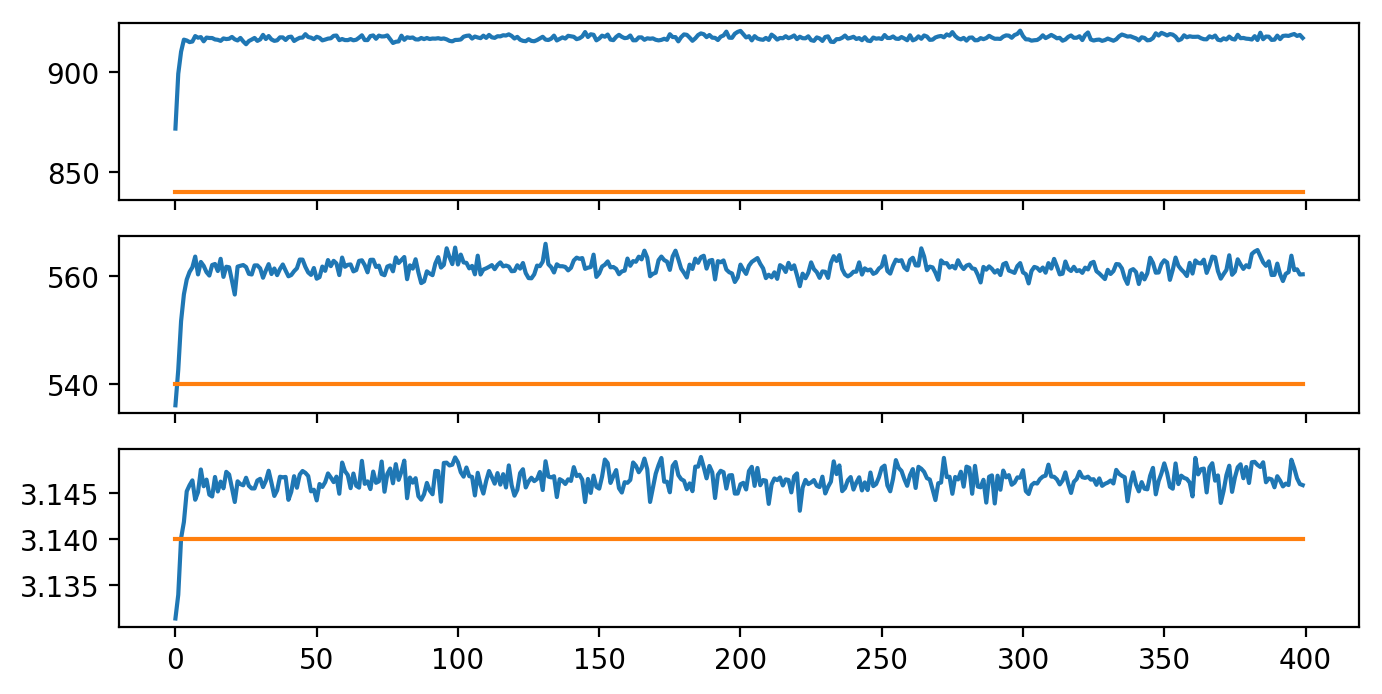

In [136]:
fig, ax = plt.subplots(3, 1, figsize=(8, 4), dpi=200, sharex=True)
for i in range(3):
    ax[i].plot(pf_points[:, i])
    ax[i].plot(odom_lidar_points[:, i])

In [137]:
# pf_points1 = np.ones(pf_points.shape[0])[:, np.newaxis] * np.array([789, 1012, 0.04])[np.newaxis, :]
# np.save("pf_true_points%d.npy"%k, pf_points)

6976.907544475285


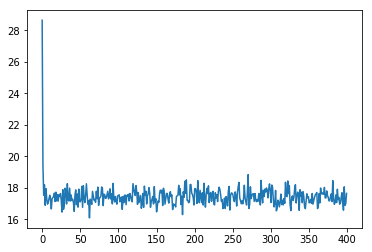

In [138]:
plt.plot(cost_functions)
print(np.sum(cost_functions[:]))

(-200, 2200)

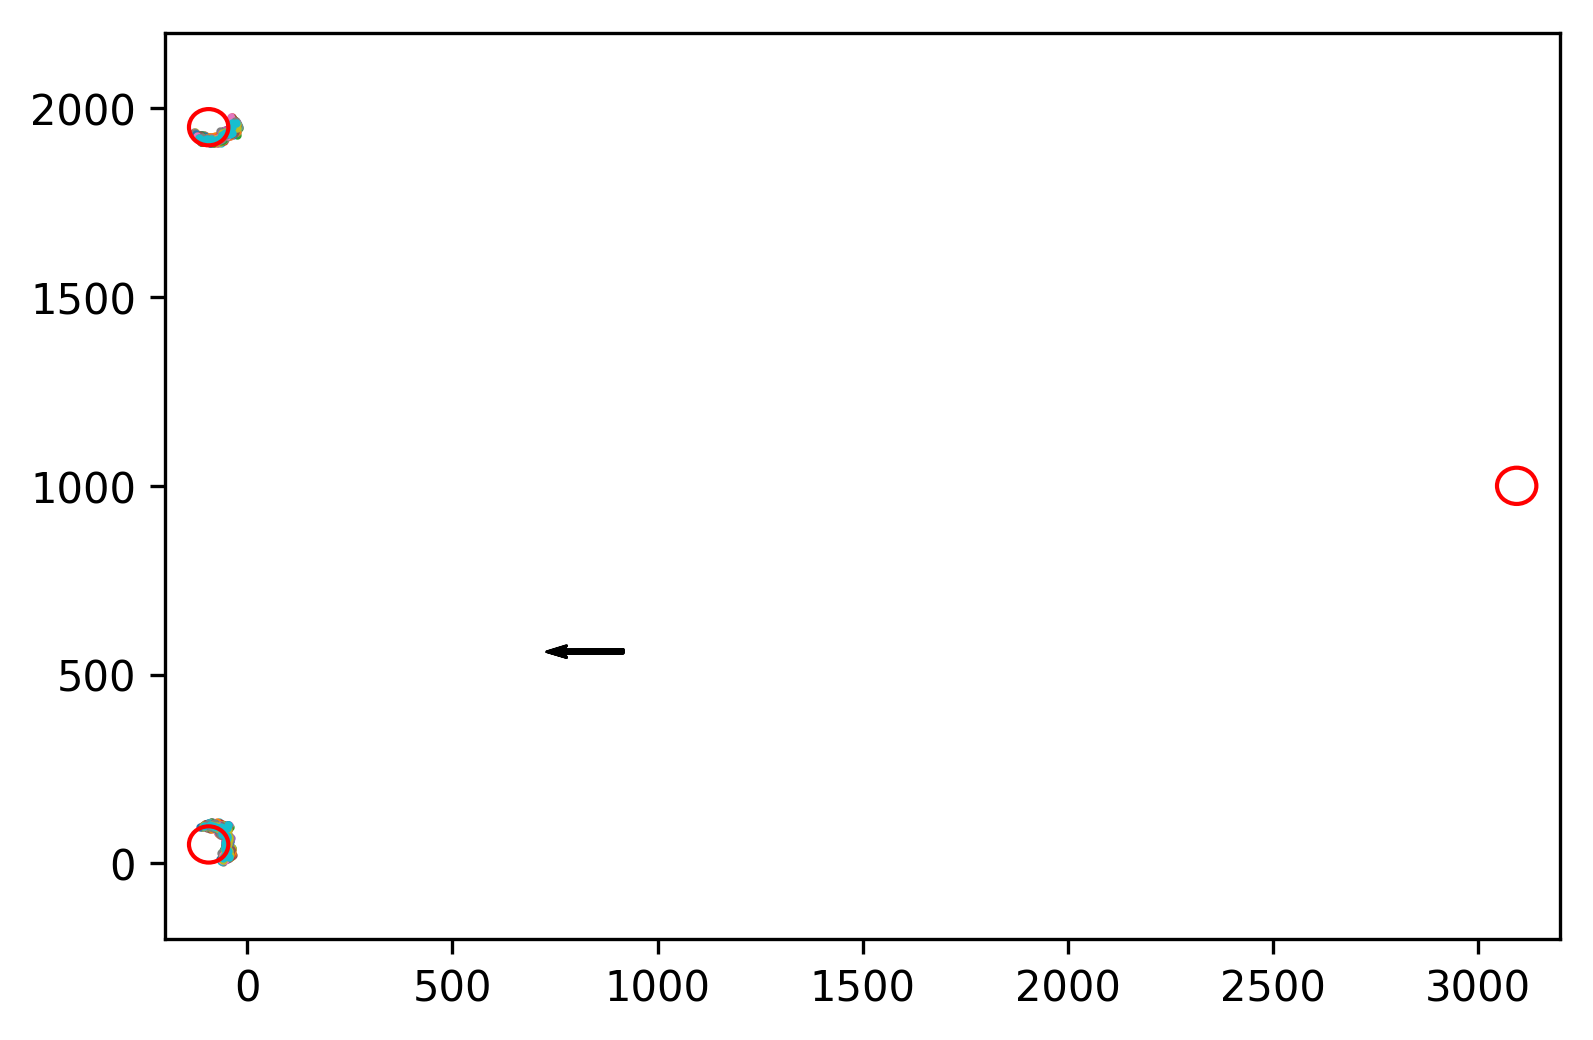

In [140]:
ind_start, ind_end = 300, 400
ps = pf_points[ind_start:ind_end]
ps1 = odom_lidar_points[ind_start:ind_end]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

for i in range(ind_start, ind_end):
    a, d = pf.get_landmarks(scans[i], pf.min_intens)
    x, y = pf.p_trans(a, d)
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, pf_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]), width=0.003)
plt.xlim(-200, 3200)
plt.ylim(-200, 2200)
# plt.xlim(3000, 3200)
# plt.ylim(1800, 2000)

In [133]:
x_coords, y_coords = pf.p_trans(*pf.get_landmarks(scans[200], pf.min_intens))
landmarks = np.array([x_coords, y_coords]).T
pf.weights(landmarks, np.array([pf_points[300]]))


-------
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2]]
[[[ 2.58723241e+02 -1.33285583e+01]
  [ 2.66765925e+02 -1.09975349e+01]
  [ 2.73394821e+02 -7.20678453e+00]
  [ 2.74324586e+02  2.24408945e+00]
  [ 2.74480656e+02  1.23802327e+01]
  [ 2.82460101e+02  1.48294069e+01]
  [ 2.87560095e+02  2.01008849e+01]
  [ 2.94083491e+02  2.40133803e+01]
  [ 2.94059630e+02  3.41475411e+01]
  [ 3.05638292e+02  3.33111110e+01]
  [ 3.12854078e+02  3.66403059e+01]
  [ 3.28151149e+02  3.25539170e+01]
  [ 3.33173370e+02  3.80245905e+01]
  [ 3.40394886e+02  4.15028129e+01]
  [ 4.21643281e-01 -7.12927117e+01]
  [-9.75599492e+00 -7.24405703e+01]
  [-2.31696006e+01 -7.59776537e+01]
  [-3.73481689e+01 -8.02011971e+01]
  [-4.01207706e+01 -7.63423234e+01]
  [-4.04853411e+01 -7.07291568e+01]
  [-5.21619533e+01 -7.33996719e+01]
  [-4.29175112e+01 -6.06679678e+01]
  [-4.89772427e+01 -5.92308884e+01]
  [-5.82242541e+01 -6.02455390e+01]
  [-6.42646409e+01 -5.89031023e+01]


NameError: name 'landm' is not defined

In [120]:
pf.beacons

array([[3094., 1000.],
       [ -94., 1950.],
       [ -94.,   50.]])

## Particles

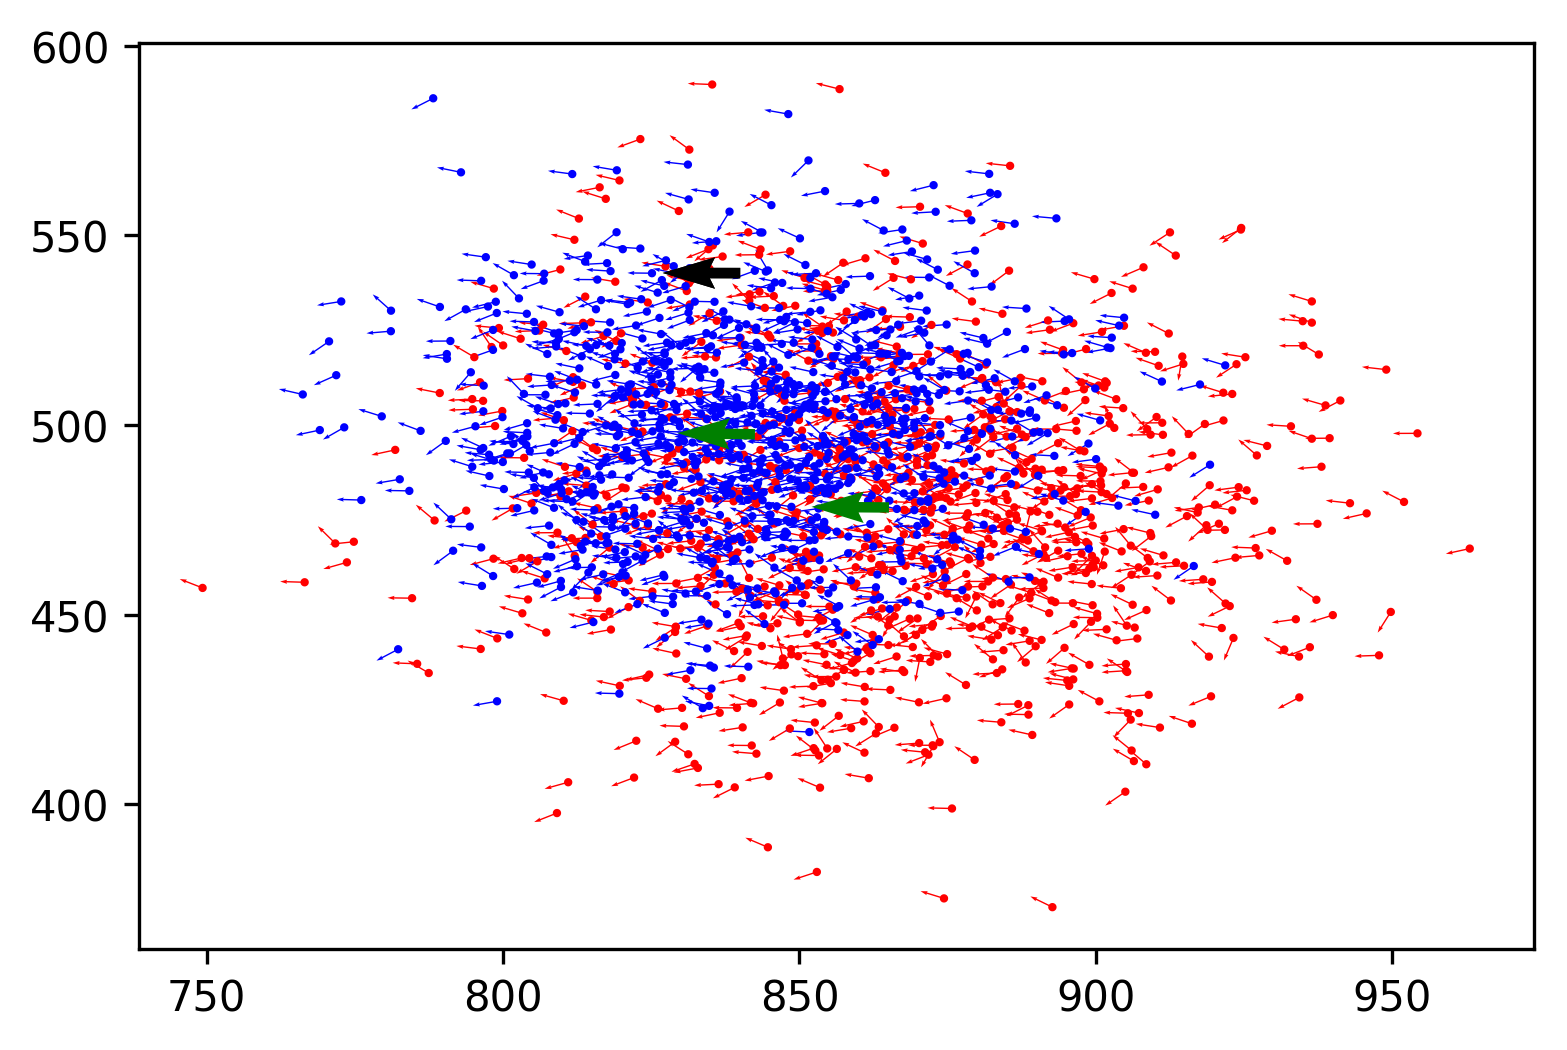

In [95]:
ind1 = 160
ind2 = 50
op1 = odom_lidar_points[ind1]
op2 = odom_lidar_points[ind2]
pf1 = pf_points[ind1]
pf2 = pf_points[ind2]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
ps = all_particles1[ind1]
ps1 = all_particles1[ind2]
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]), width=0.001, color="red")
ax.quiver(ps1[:, 0], ps1[:, 1], np.cos(ps1[:, 2]), np.sin(ps1[:, 2]), width=0.001, color="blue")
ax.scatter(ps[:, 0], ps[:, 1], c="red", s=all_weights[ind1] * 1000)
ax.scatter(ps1[:, 0], ps1[:, 1], c="blue", s=all_weights[ind2] * 1000)
ax.quiver(op1[0], op1[1], np.cos(op1[2]), np.sin(op1[2]))
ax.quiver(op2[0], op2[1], np.cos(op2[2]), np.sin(op2[2]))
ax.quiver(pf1[0], pf1[1], np.cos(pf1[2]), np.sin(pf1[2]), color="green")
ax.quiver(pf2[0], pf2[1], np.cos(pf2[2]), np.sin(pf2[2]), color="green")
# plt.xlim(500, 1000)
# plt.ylim(500, 1500)
# plt.xlim(500, 1000)
# plt.ylim(500, 1500)

## The first particles

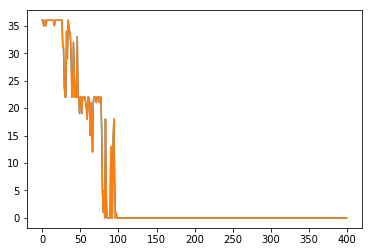

In [87]:
plt.plot([x["num_good_landmarks"] for x in best_particles_information][:])
plt.plot([x["num_good_landmarks"] for x in best_particles_information][:])

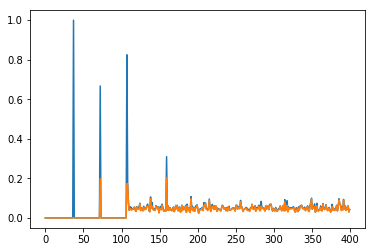

In [57]:
plt.plot([x["weights"][0] for x in best_particles_information][:])
plt.plot([x["weights"][1] for x in best_particles_information][:])

In [71]:
best_particles_information[200]['particles'][0]

array([993.0245901 , 474.30021909,   3.02466794])

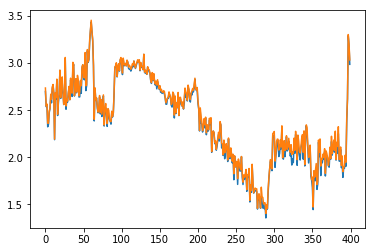

In [239]:
plt.plot([x["cost_function"][0] for x in best_particles_information][:])
plt.plot([x["cost_function"][1] for x in best_particles_information][:])

In [29]:
best_particles_information[307]["cost_function"][9]

2.270624360334559

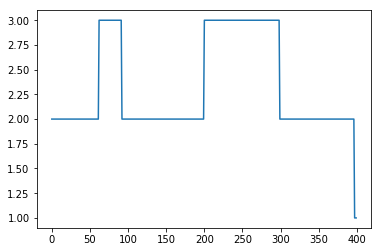

In [109]:
plt.plot(np.sum(all_is_beacon_seeing, axis=1))

# Look at many scans

In [130]:
def draw_pf_points(k, pf_points, true_pf_points):
    fig, ax = plt.subplots(3, 1, figsize=(8, 4), dpi=200, sharex=True)
    ax[0].set_title("Scan number %d"%k)
    for i in range(3):
        ax[i].plot(pf_points[:, i])
        ax[i].plot(true_pf_points[:, i])
    plt.show()
        
def operate_scan(k):
    scans = np.load("laser_scans%d.npy"%k)
    N = scans.shape[0]
    raw_odom_coords = np.load("odom_coords%d.npy"%k)
    raw_odom_coords[:, :2] *= 1000

    start_point = START_POINTS[k - 1]
    lidar_point = LIDAR_POINTS[k - 1]
    start_lidar_point = cvt_local2global(lidar_point, start_point)
    odom_diff = cvt_global2local(raw_odom_coords, raw_odom_coords[0])
    odom_robot_points = cvt_local2global(odom_diff, start_point)
    odom_lidar_points = cvt_local2global(lidar_point, odom_robot_points)
    
    delta_coords = cvt_global2local(odom_lidar_points, np.roll(odom_lidar_points, 1, axis=0))
    delta_coords[0] = np.array([0, 0, 0])
    delta_coords[-1] = np.array([0, 0, 0])
    
    pf = ParticleFilter(start_x=start_lidar_point[0], start_y=start_lidar_point[1], 
                    start_angle=start_lidar_point[2], **PF_PARAMS)
    pf_points = []
    for i in range(N):
        pf_points.append(pf.localisation(delta_coords[i], scans[i]))
    pf_points = np.array(pf_points)
    true_pf_points = np.load("pf_true_points%d.npy"%k)
    draw_pf_points(k, pf_points, true_pf_points)

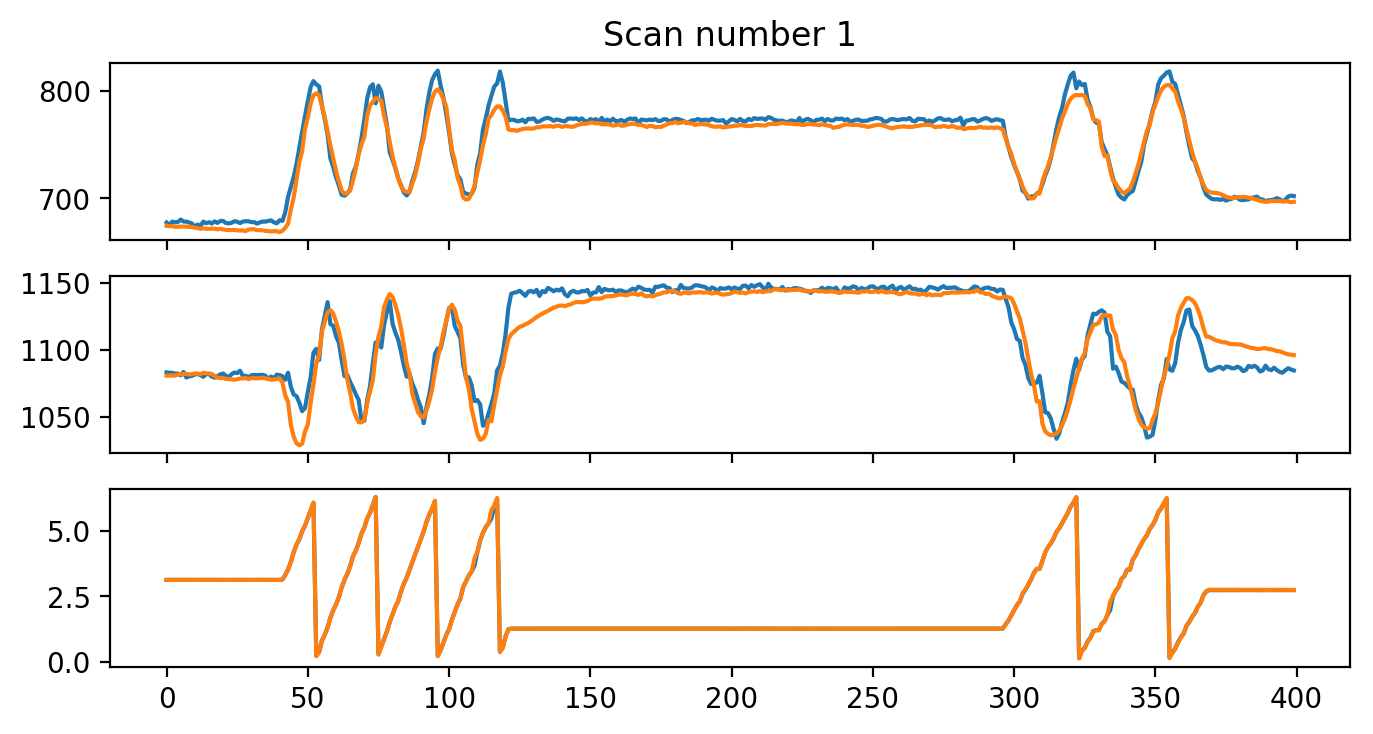

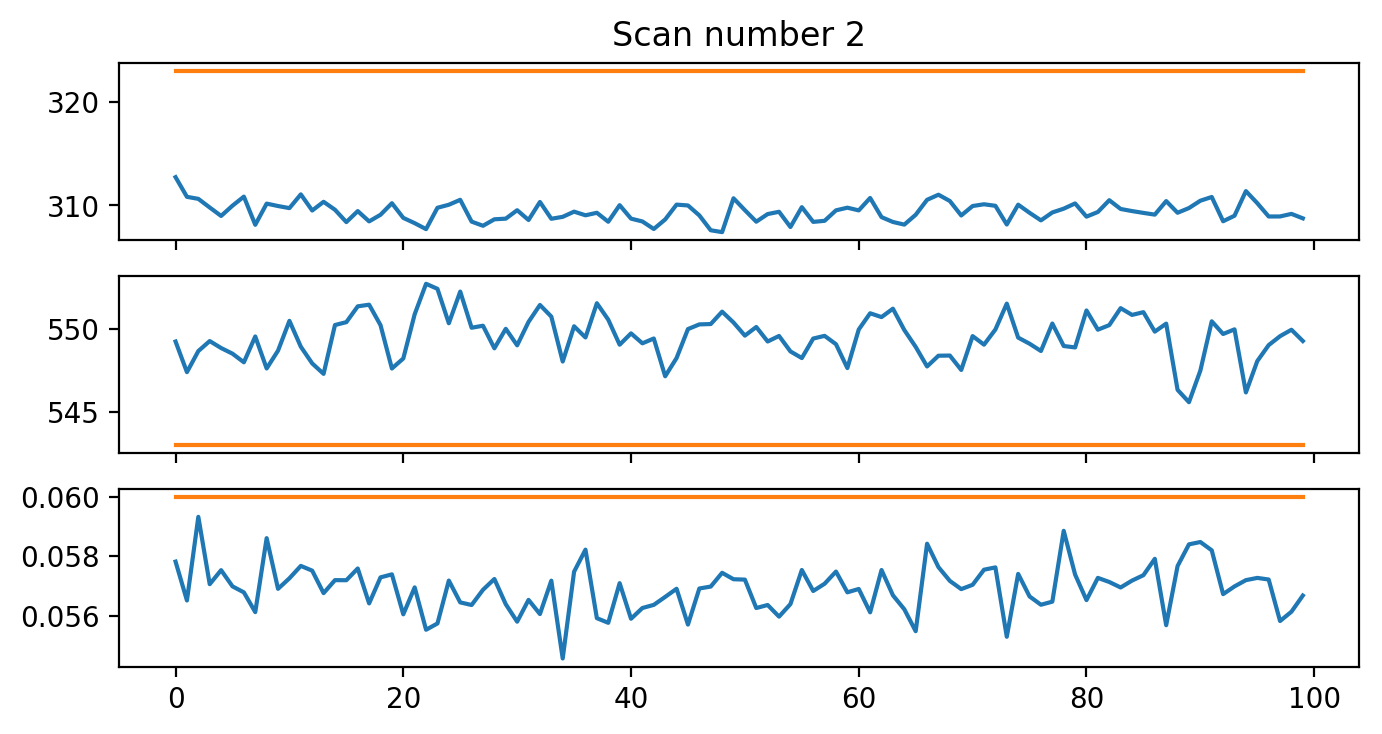

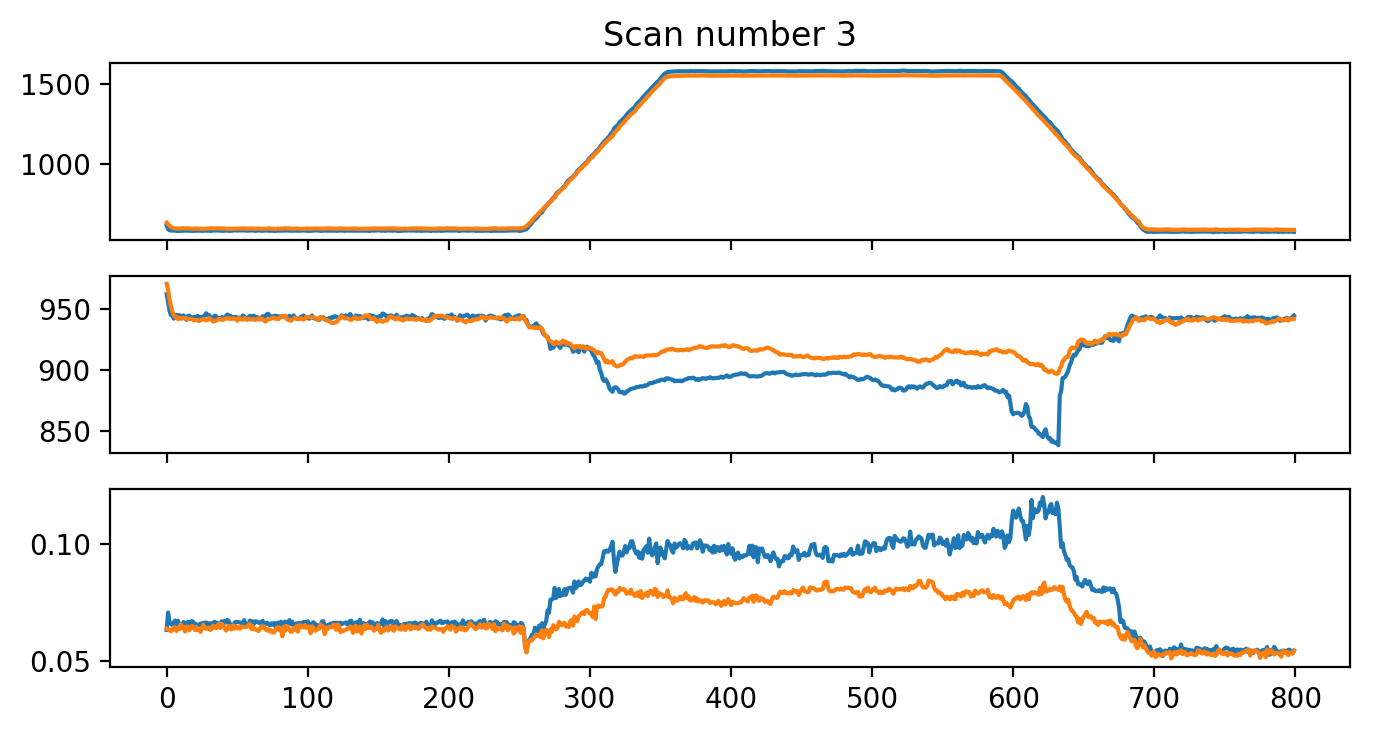

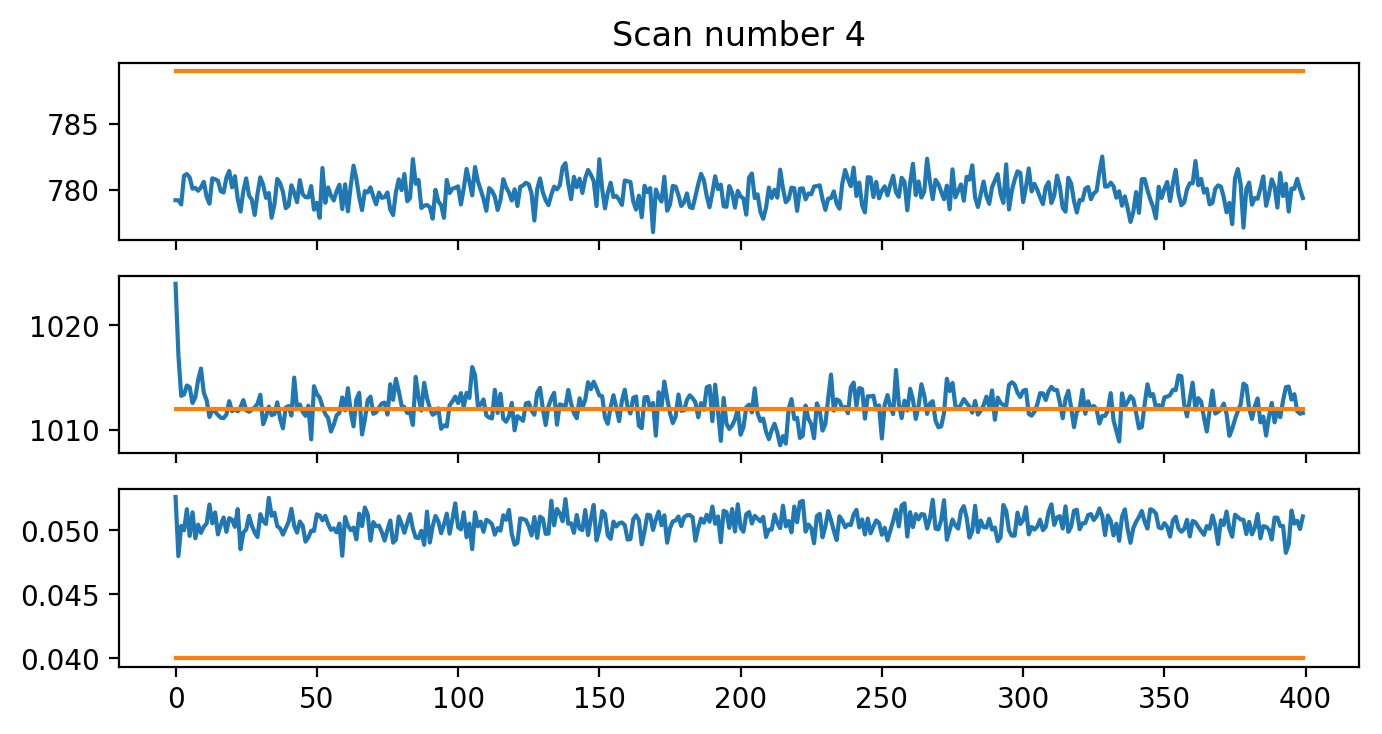

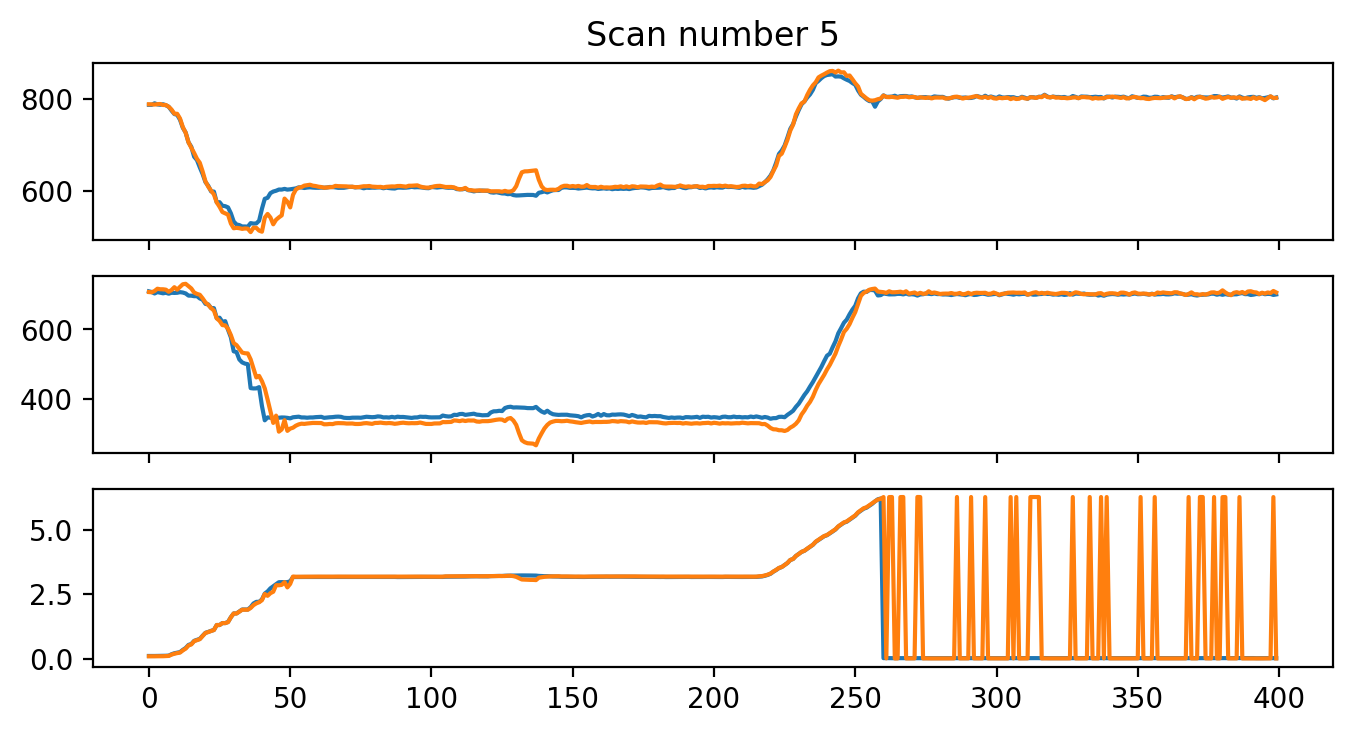

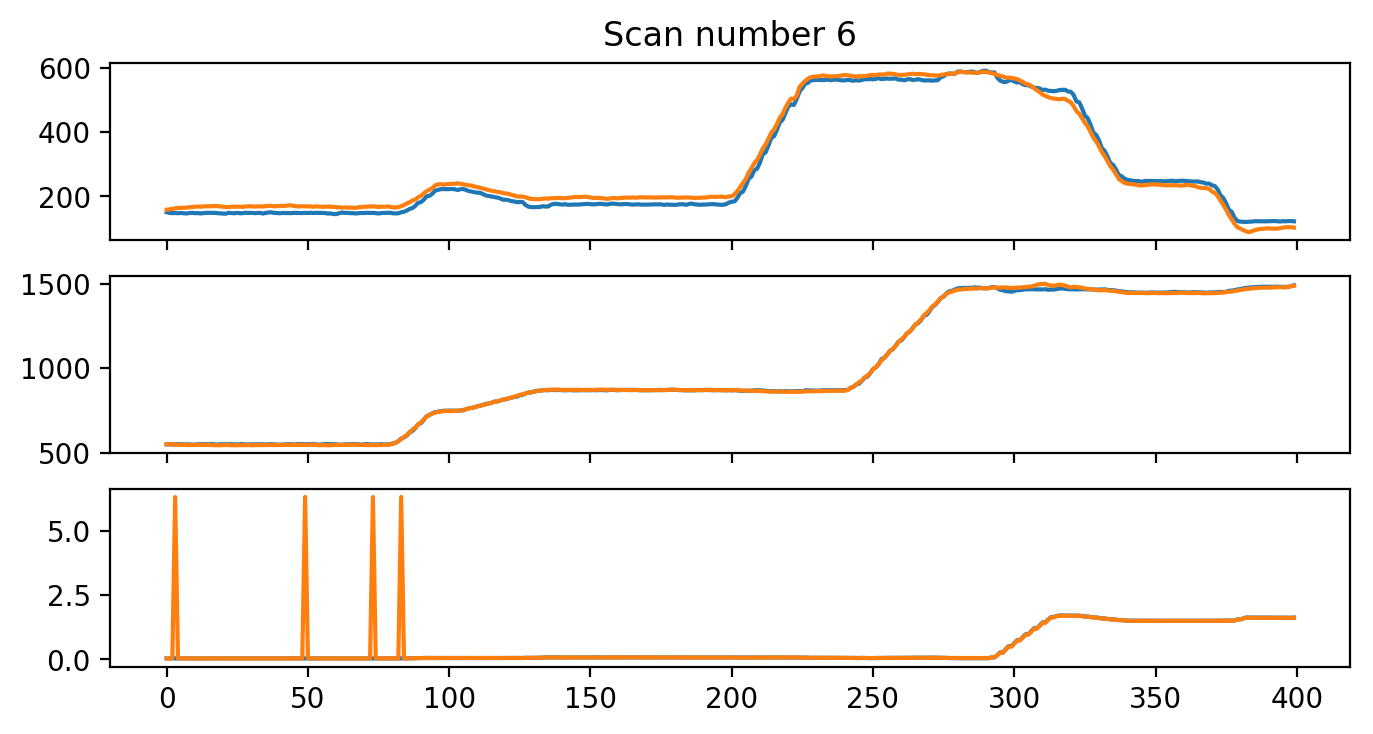

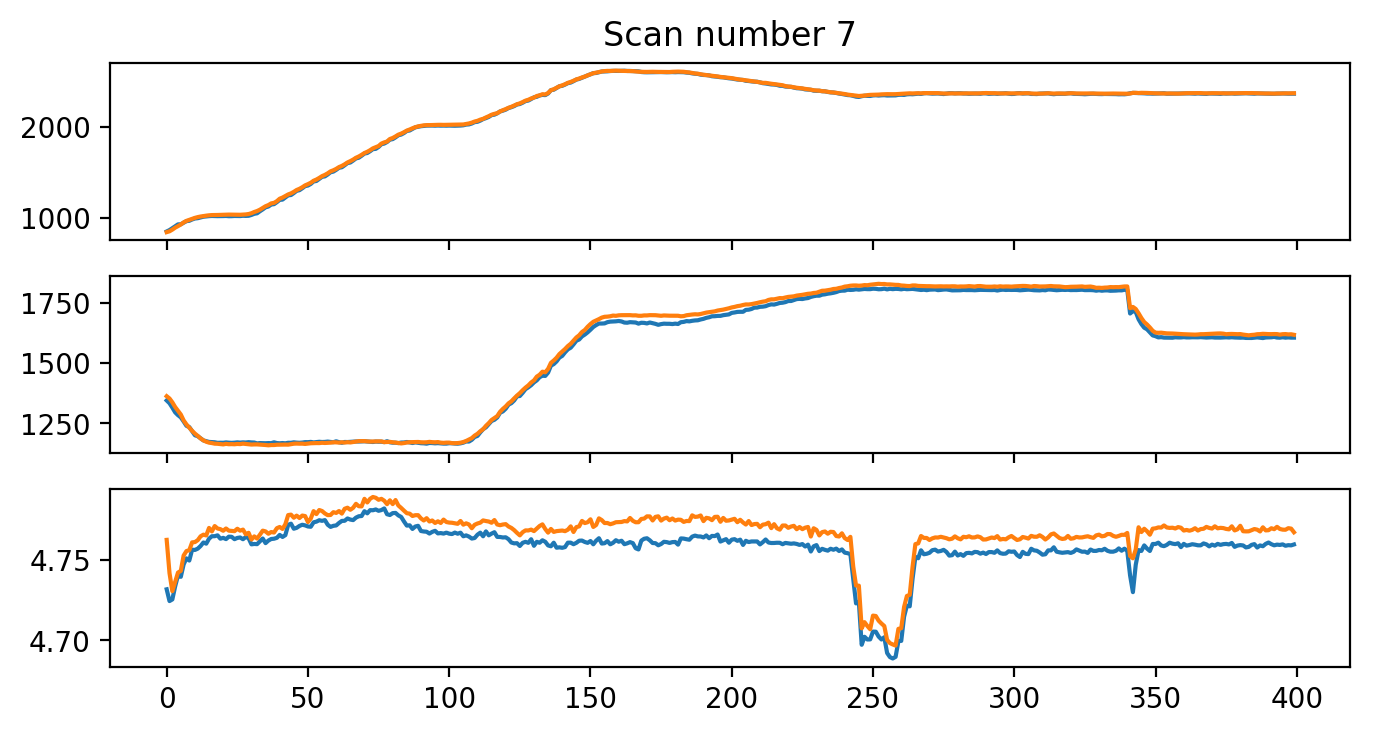

In [132]:
PF_PARAMS = {"particles_num": 1000,
             "sense_noise": 0.75,
             "distance_noise": 8,
             "angle_noise": 0.1,
             "min_intens": 3000,
             "max_dist": 3700,
             "k_angle": 120,
             "beac_dist_thresh": 150,
             "num_is_near_thresh": 0.1,
             "dist_offset": 0,
             "k_bad": 1}

for i in range(1, 8):
    operate_scan(i)

# Find beacons

In [329]:
def fun(beacon, points):
    return np.sqrt((beacon[0] - points[:, 0]) ** 2 + (beacon[1] - points[:, 1]) ** 2) - BEAC_R

def find_beacon(points, init_beacon):
    return scipy.optimize.least_squares(fun, init_beacon, args=(points,), loss="linear")

def get_xy_scan_points(scan, sc_point):
    x, y = pf.p_trans(*pf.get_landmarks(scan, pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    points = cvt_local2global(points, sc_point)[:, 0:2]
    return points

def devide_points_beacons(points, beacons):
    beac_dist = np.sqrt((points[:, 0, np.newaxis] - beacons[np.newaxis, :, 0]) ** 2 +\
        (points[:, 1, np.newaxis] - beacons[np.newaxis, :, 1]) ** 2)
    points_ind = np.argmin(beac_dist, axis=1)
    min_beac_dist = np.min(beac_dist, axis=1)
    return points_ind, min_beac_dist

def get_new_beacons(old_beacons, points):
    beac_dist = np.sqrt((points[:, 0, np.newaxis] - old_beacons[np.newaxis, :, 0]) ** 2 +\
        (points[:, 1, np.newaxis] - old_beacons[np.newaxis, :, 1]) ** 2)
    points_ind = np.argmin(beac_dist, axis=1)
    min_beac_dist = np.min(beac_dist, axis=1)
    new_beacons = old_beacons.copy()
    seen_beacons = np.zeros(3, dtype=np.int32)
    for i in range(3):
        points_beac = points[(min_beac_dist < pf.beac_dist_thresh) * (points_ind == i)]
        if points_beac.shape[0] > 3:
            new_beacon = find_beacon(points_beac, pf.beacons[i].copy()).x
            new_beacons[i] = new_beacon
            seen_beacons[i] = 1
    return new_beacons, seen_beacons

def get_beacon_angles(beacons, points):
    dists = beacons - points[:, :2]
    angles = np.arctan2(dists[:, 1], dists[:, 0])
    return (points[:, 2] - angles) % (2 * np.pi)

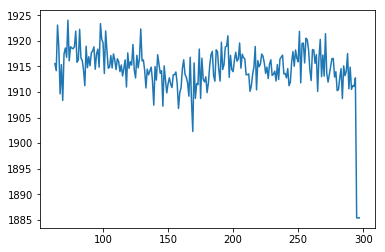

In [330]:
distances = []
old_distances = []
all_new_beacons = []
all_seen_beacons = []
for i in range(N):
    points = get_xy_scan_points(scans[i], pf_points[i])
    new_beacons, seen_beacons = get_new_beacons(pf.beacons, points)
    all_new_beacons.append(new_beacons)
    all_seen_beacons.append(seen_beacons)
    distances.append(np.linalg.norm(new_beacons[2] - new_beacons[1]))
    old_distances.append(np.linalg.norm(pf.beacons[2] - pf.beacons[1]))

all_seen_beacons = np.array(all_seen_beacons)
all_new_beacons = np.array(all_new_beacons)
distances = np.array(distances)
inds = ~np.logical_or(np.all(all_new_beacons[:, 1] == pf.beacons[1], axis=1),
                     np.all(all_new_beacons[:, 2] == pf.beacons[2], axis=1))

# distances[inds] = old_distances[0]
plt.plot(np.arange(N)[inds], distances[inds])
# plt.plot(old_distances)

In [341]:
test_points = pf_points.copy()
test_points[:, :2] = pf_points[0, :2]

(-100, 100)

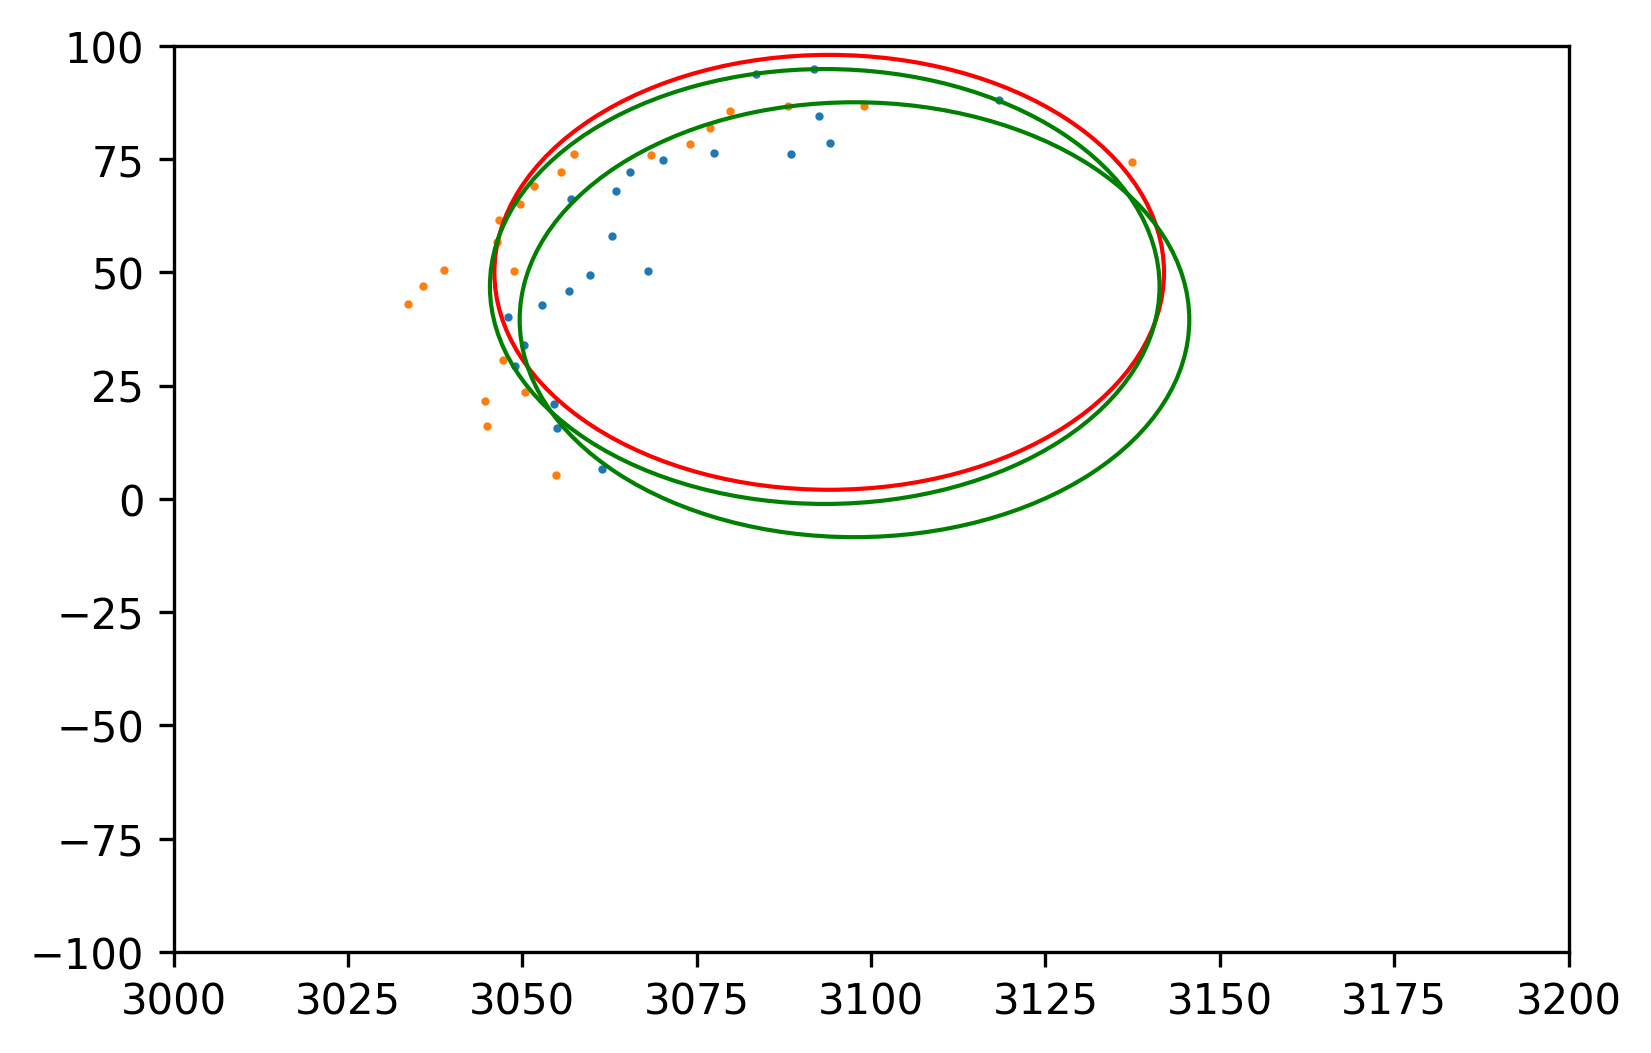

In [342]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
ind = 160
for i in [90, 150]:
    x, y = pf.p_trans(*pf.get_landmarks(scans[i], pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, test_points[i])[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
for i in [90, 150]:
    for b in all_new_beacons[i]:
        ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="g"))
# plt.xlim(-200, 3500)
# plt.ylim(-200, 2200)
plt.xlim(3000, 3200)
plt.ylim(-100, 100)

## Distances from robot

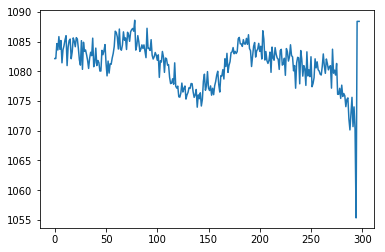

In [333]:
beacon_ind = 2
distances = np.linalg.norm(all_new_beacons[:, beacon_ind, :] - pf_points[:, :2], 
                               axis=1)[all_seen_beacons[:, beacon_ind] == 1]
plt.plot(np.arange(N)[all_seen_beacons[:, beacon_ind] == 1], distances)

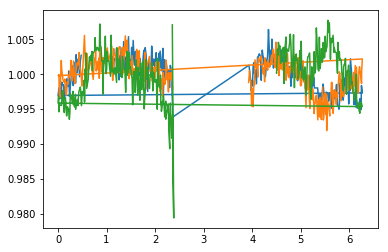

In [327]:
for beacon_ind in range(3):
    beacon_distances = np.linalg.norm(all_new_beacons[:, beacon_ind, :] - pf_points[:, :2], 
                               axis=1)[all_seen_beacons[:, beacon_ind] == 1]
    beacon_angles = get_beacon_angles(all_new_beacons[:, beacon_ind, :], pf_points)[all_seen_beacons[:, beacon_ind] == 1]
    plt.plot(beacon_angles, beacon_distances / np.mean(beacon_distances))

## Intensities

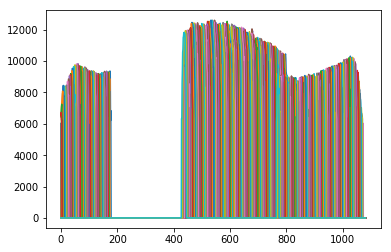

In [200]:
for i in range(50, 160):
    scan_ind = i
    intens = scans[scan_ind, :, 1]
    intens[scans[scan_ind, :, 1]< 6000] = 0
    plt.plot(intens)

In [347]:
beacon_intens = []
beacon_angles = []
beacon_distances = []
for i in range(N):
    scan_angles, scan_distances = pf.get_landmarks(scans[i], pf.min_intens)
    scan_intens = scans[i, scans[i, :, 1] > pf.min_intens, 1]
    
    a = all_new_beacons[i, :, :] - pf_points[i, np.newaxis, :2]
    beacon_angles1 = (np.arctan2(a[:, 1], a[:, 0]) - pf_points[i, np.newaxis, 2]) % (np.pi * 2)
    dangles = (beacon_angles1[:, np.newaxis] - scan_angles[np.newaxis, :]) % (np.pi * 2)
    dangles = np.where(dangles < np.pi, dangles, 2 * np.pi - dangles)
    
    beacon_angles.append(beacon_angles1)
    beacon_intens1 = np.zeros(3)
    beacon_distances1 = np.zeros(3)
    for j in range(3):
        if scan_intens[np.abs(dangles[j, :]) < 0.1].shape[0] > 0:
            beacon_intens1[j] = np.max(scan_intens[np.abs(dangles[j, :]) < 0.1])
            beacon_distances1[j] = scan_distances[np.argmax(scan_intens[np.abs(dangles[j, :]) < 0.1])]
    beacon_intens.append(beacon_intens1)
    beacon_distances.append(beacon_distances1)
beacon_intens = np.array(beacon_intens)
beacon_angles = np.array(beacon_angles)
beacon_distances = np.array(beacon_distances)

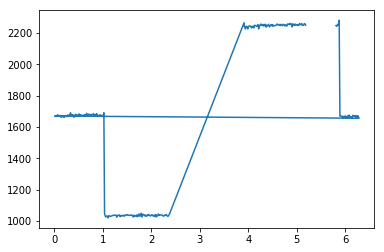

In [352]:
for j in range(1):
    distances = beacon_distances[:, j][beacon_intens[:, j] != 0]
    plt.plot(beacon_angles[:, j][beacon_distances[:, j] != 0], distances)

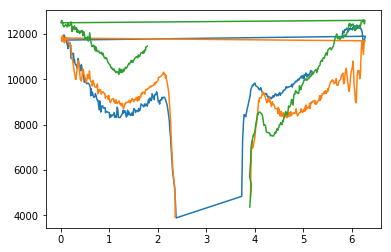

In [114]:
for j in range(3):
    plt.plot(beacon_angles[:, j][beacon_intens[:, j] != 0], beacon_intens[:, j][beacon_intens[:, j] != 0])

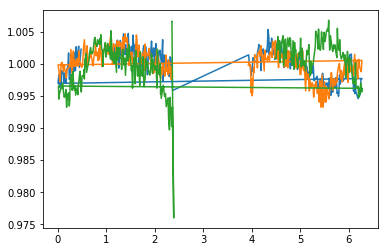

In [116]:
for beacon_ind in range(3):
    beacon_distances = np.linalg.norm(all_new_beacons[:, beacon_ind, :] - pf_points[:, :2], 
                               axis=1)[all_seen_beacons[:, beacon_ind] == 1]
    beacon_angles = get_beacon_angles(all_new_beacons[:, beacon_ind, :], pf_points)[all_seen_beacons[:, beacon_ind] == 1]
    plt.plot(beacon_angles, beacon_distances / np.mean(beacon_distances))

In [63]:
np.abs(dangles) > 0.5

array([[False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       [ True,  True, False],
       [ True,  True, False],
       [ True,  True, False],
       [ True,  True, False],
       [ True,  True, False],
       [ T

# Trianglulation

In [258]:
def fun_1(X, points, num_beacons):
    beacons = pf.beacons[num_beacons]
    points = cvt_local2global(points, X)[:, 0:2]
    r = np.sum((beacons - points) ** 2, axis=1) ** 0.5 - BEAC_R
    return r

In [263]:
ind = 160
x, y = pf.p_trans(*pf.get_landmarks(scans[ind], pf.min_intens))
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y

init_X = pf_points[ind].copy()
apr_points = get_xy_scan_points(scans[ind], init_X)
beacons_len = np.sum((pf.beacons[np.newaxis, :, :] - apr_points[:, np.newaxis, :]
                     ) ** 2, axis=2) ** 0.5
points = points[np.min(beacons_len, axis=1) < pf.beac_dist_thresh]
num_beacons = np.argmin(beacons_len[np.min(beacons_len, axis=1) < pf.beac_dist_thresh], axis=1)

In [268]:
res = scipy.optimize.least_squares(fun_1, init_X,
                                   args=[points, num_beacons], ftol=1e-3)
tr_point = res.x
tr_point

array([2135.29638423,  539.82984505,    6.27343678])

In [265]:
np.sqrt(np.sum(fun_1(init_X, points, num_beacons).round() ** 2))

31.796226191169293

In [266]:
np.sqrt(np.sum(fun_1(tr_point, points, num_beacons).round() ** 2))

30.04995840263344

(-200, 2200)

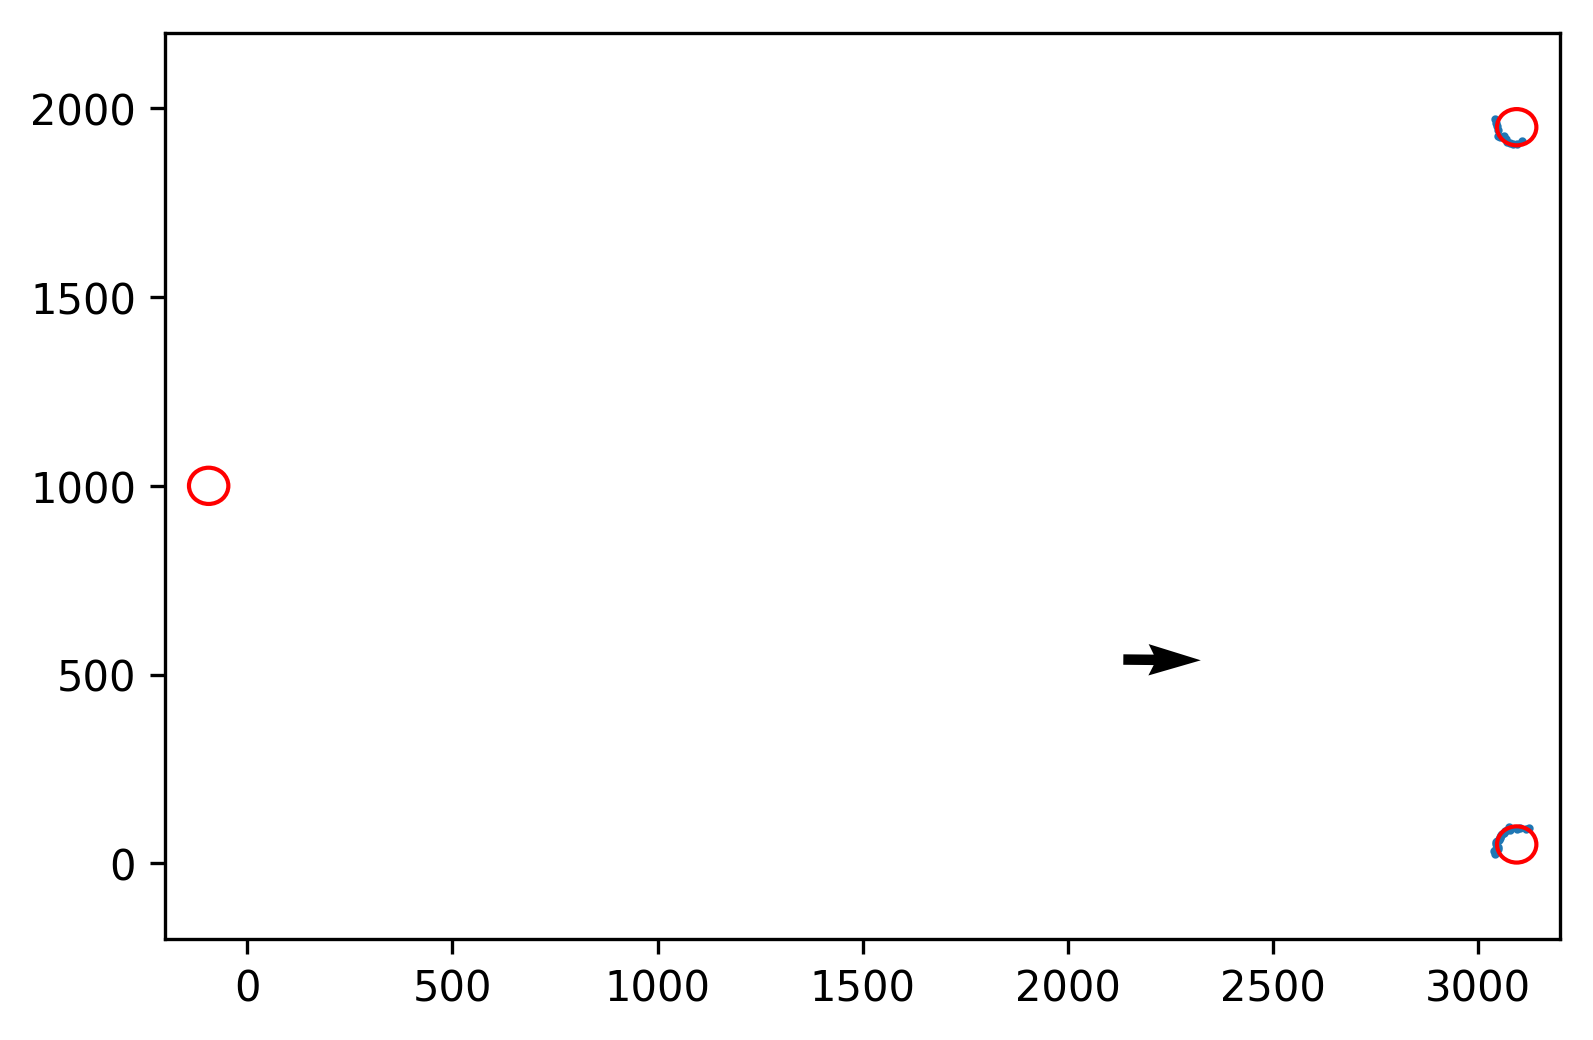

In [267]:
ind_start, ind_end = 160, 161
ps = np.array([tr_point])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
# init_X = np.array([770, 1150, 1.26])
for i in range(ind_start, ind_end):
    x, y = pf.p_trans(*pf.get_landmarks(scans[i], pf.min_intens))
    points = np.zeros((len(x), 3))
    points[:, 0] = x
    points[:, 1] = y
    ax.scatter(*cvt_local2global(points, tr_point)[:, 0:2].T,  s=1)
    
for b in pf.beacons:
    ax.add_artist(plt.Circle(b, BEAC_R, linewidth=1, fill=False, color="r"))
    
ax.quiver(ps[:, 0], ps[:, 1], np.cos(ps[:, 2]), np.sin(ps[:, 2]))
plt.xlim(-200, 3200)
plt.ylim(-200, 2200)

In [707]:
tr_point

array([605.74504712, 353.86290896,   3.18059852])

In [708]:
init_X

array([612.39469032, 337.31536983,   3.19436621])

In [65]:
from multiprocessing import Pool
pool = Pool()

/usr/lib/python3.5/multiprocessing/pool.py:44: RuntimeWarning: overflow encountered in exp
  return list(map(*args))
/usr/lib/python3.5/multiprocessing/pool.py:44: RuntimeWarning: overflow encountered in exp
  return list(map(*args))
/usr/lib/python3.5/multiprocessing/pool.py:44: RuntimeWarning: overflow encountered in exp
  return list(map(*args))
/usr/lib/python3.5/multiprocessing/pool.py:44: RuntimeWarning: overflow encountered in exp
  return list(map(*args))
